In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
    dropfeat = [i.replace('\n','') for i in d.readlines()]

In [3]:
# with open('test_ind.pickle', 'rb') as handle:
#     test_ind = pickle.load(handle)

# with open('train_ind.pickle', 'rb') as handle:
#     train_ind = pickle.load(handle)
    
# print(len(train_ind),len(test_ind))    
# train_ind,test_ind = train_test_split(train_ind+test_ind, test_size=0.3, random_state=42)

radius_range_dirs = []
for i in glob('cluster/*.*'):
    try:
        radstr = float(os.path.basename(i))
        # if radstr>=1.4:
        radius_range_dirs.append(os.path.basename(i))
    except:
        continue

radius_range = sorted(radius_range_dirs)

train_ind,test_ind=radius_range[0::2],radius_range[1::2]

train_ind = list(map(float,train_ind))
test_ind = list(map(float,test_ind))
train_ind, test_ind = train_test_split(train_ind+test_ind, test_size=0.1, random_state=42)

In [4]:
print(len(train_ind),len(test_ind))    

594 67


In [5]:
train = []
test = []



recover_train = []
recover_test = []

traincnt = 0
testcnt = 0


for k in train_ind:
    rad = f"{k:.2f}"
    traindf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
    traindf = traindf[traindf['Pair_Energies'].abs()>=1e-12]
    train.append(traindf)
    recover_train.append((rad,traincnt,len(traindf)))
    traincnt+=1
        
for l in test_ind:
    rad = f"{l:.2f}"
    testdf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
    testdf = testdf[testdf['Pair_Energies'].abs()>=1e-12]
    test.append(testdf)                    
    recover_test.append((rad,testcnt,len(testdf)))
    testcnt+=1

In [6]:
rename = {'h$_{qq}^{0}$':'h$_{q}$',
'$(F_{q})_{0}$':'$F_{q}$',
'$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
'$(\\eta_{q})_{0}$':'$\\eta_{q}$',
'$(\\omega_{q})_{0}$':'$\\omega_{q}$',
'$(\\eta_{s})_{0}$':'$\\eta_{s}$',
'h$_{ss}^{0}$':'h$_{s}$',
'$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
'$(F_{s})_{0}$':'$F_{s}$',
'$(\\omega_{s})_{0}$':'$\\omega_{s}$',
'$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
'$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
'h$_{pp}^{0}$': '(h$_{p}$)$_{0}$',
'h$_{pp}^{1}$': '(h$_{p}$)$_{1}$',
'h$_{pp}^{2}$': '(h$_{p}$)$_{2}$',
'h$_{pp}^{3}$': '(h$_{p}$)$_{3}$',
'h$_{rr}^{0}$': '(h$_{r}$)$_{0}$',
'h$_{rr}^{1}$': '(h$_{r}$)$_{1}$',
'h$_{rr}^{2}$': '(h$_{r}$)$_{2}$',
'h$_{rr}^{3}$': '(h$_{r}$)$_{3}$',
'h$_{pq}^{0}$':'(h$_{pq}$)$_{0}$',
'h$_{pq}^{1}$':'(h$_{pq}$)$_{1}$',
'h$_{pq}^{2}$':'(h$_{pq}$)$_{2}$',
'h$_{pq}^{3}$':'(h$_{pq}$)$_{3}$',
'h$_{pr}^{0}$':'(h$_{pr}$)$_{0}$',
'h$_{pr}^{1}$':'(h$_{pr}$)$_{1}$',
'h$_{pr}^{2}$':'(h$_{pr}$)$_{2}$',
'h$_{pr}^{3}$':'(h$_{pr}$)$_{3}$',
'h$_{rs}^{0}$':'(h$_{rs}$)$_{0}$',
'h$_{rs}^{1}$':'(h$_{rs}$)$_{1}$',
'h$_{rs}^{2}$':'(h$_{rs}$)$_{2}$',
'h$_{rs}^{3}$':'(h$_{rs}$)$_{3}$',
'typ_0':'$type_0$',
'typ_1':'$type_1$',
'typ_2':'$type_2$',
'typ_3':'$type_3$'}

In [7]:
train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)

In [8]:
pd.concat([train_df,test_df])[['$type_0$','$type_2$']].value_counts().sum()

np.int64(274972)

In [9]:
pd.concat([train_df,test_df])[['$type_2$']].value_counts()/pd.concat([train_df,test_df])[['$type_2$']].value_counts().sum()

$type_2$
4           0.278563
0           0.195758
3           0.138094
8           0.089045
9           0.057744
11          0.049412
7           0.048249
5           0.037938
10          0.033891
6           0.022493
1           0.018998
12          0.017405
2           0.012409
Name: count, dtype: float64

In [10]:
pd.concat([train_df,test_df])[['$type_0$']].value_counts()/pd.concat([train_df,test_df])[['$type_0$']].value_counts().sum()

$type_0$
4           0.285691
3           0.171188
0           0.147571
8           0.098021
9           0.056362
7           0.054366
11          0.045219
6           0.030803
5           0.029807
10          0.028145
1           0.022093
12          0.016980
2           0.013754
Name: count, dtype: float64

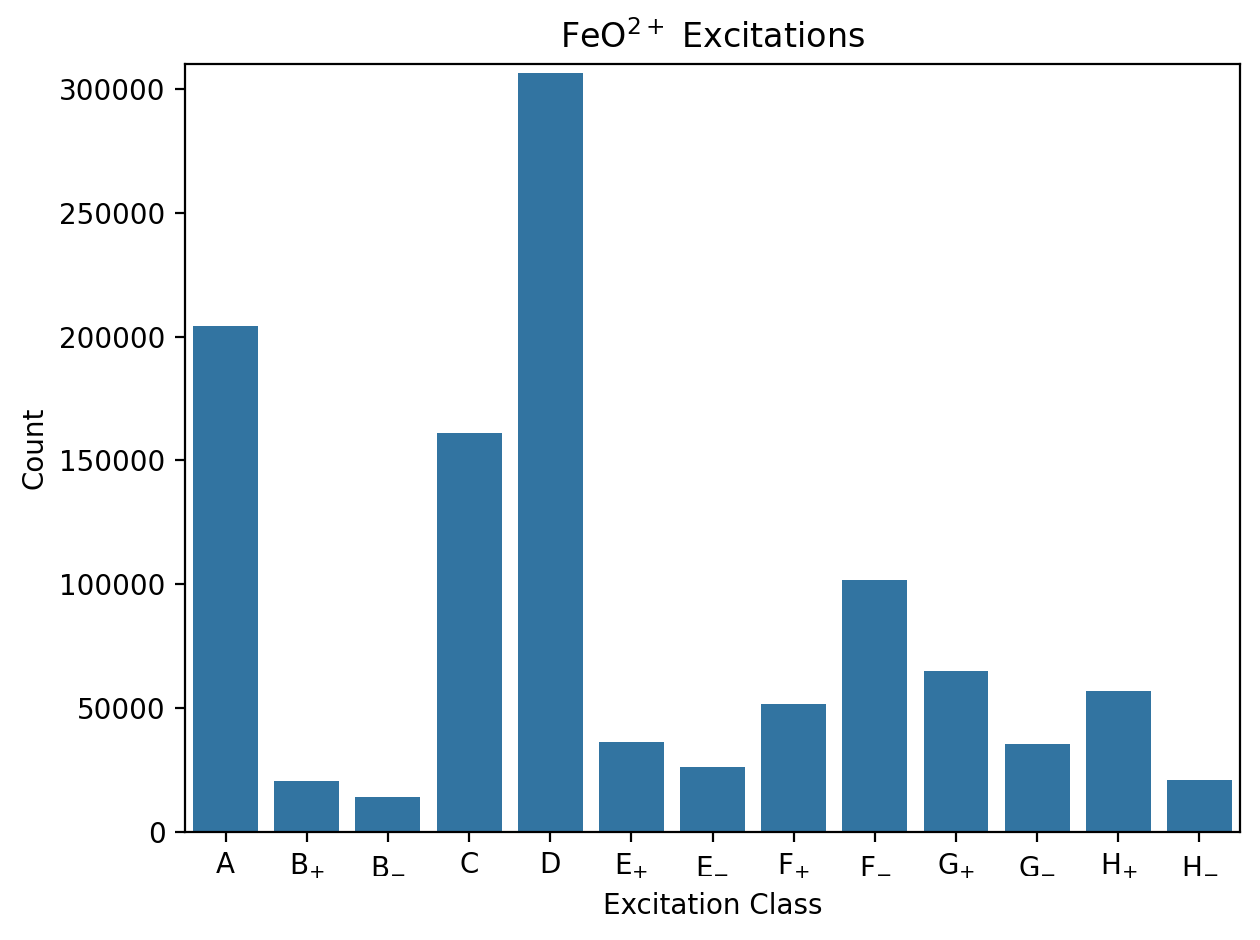

In [11]:
counttypes=pd.concat([pd.concat([train_df,test_df])[i].value_counts() for i in train_df.columns if 'typ' in i],axis=1).T.sum(axis=0).sort_index()
counttypes.index=[{1:"A", 2:"B$_{+}$", 3:"B$_{-}$", 4:"C", 5:"D", 6:"E$_{+}$", 7:"E$_{-}$", 8:"F$_{+}$", 9:"F$_{-}$", 10:"G$_{+}$", 11:"G$_{-}$", 12:"H$_{+}$", 13:"H$_{-}$"}[t] for t in counttypes.index+1]
sns.barplot(data=counttypes.reset_index(),x='index',y=0,color=sns.color_palette('Paired')[1])
plt.ylabel('Count')
plt.xlabel('Excitation Class')
plt.ylim(0,np.round(counttypes.max(), -4))
plt.title('FeO$^{2+}$ Excitations')
plt.tight_layout()
plt.savefig('images/excitation_barplot.png',dpi=300,bbox_inches='tight')
plt.show()

In [12]:
X_train = train_df.drop(columns=['Pair_Energies']).values
X_test = test_df.drop(columns=['Pair_Energies']).values

y_train = train_df['Pair_Energies'].values
y_test = test_df['Pair_Energies'].values

In [13]:
X_train.shape

(247101, 102)

In [14]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [15]:
np.min(np.floor(np.log10(np.abs(np.concat([y_train,y_test])))))

np.float64(-12.0)

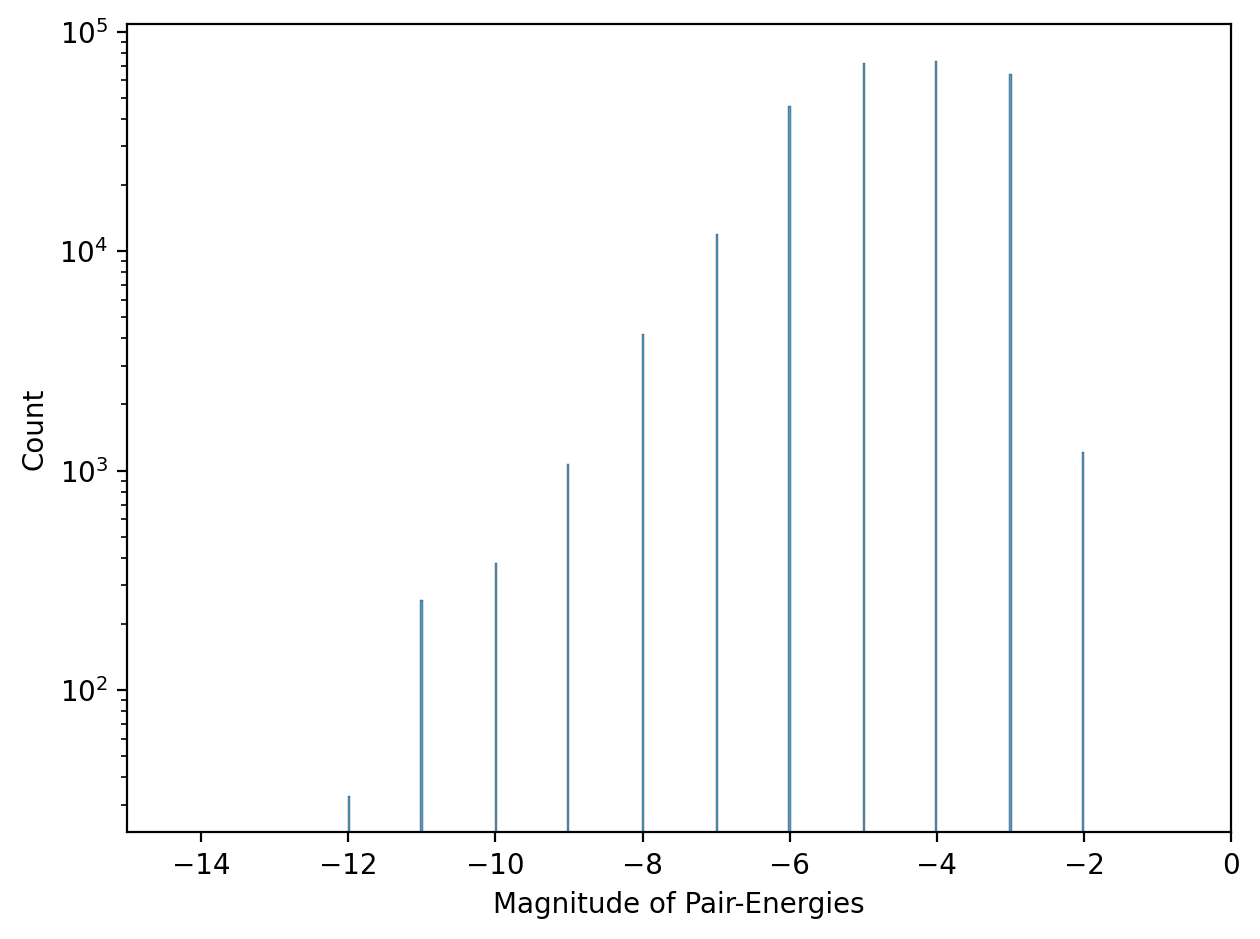

In [16]:
sns.histplot(np.floor(np.log10(np.abs(np.concat([y_train,y_test])))))
plt.xlim(-15,0)
# plt.ylim(0,10**5)
plt.yscale('log')
plt.xlabel("Magnitude of Pair-Energies")
plt.tight_layout()
plt.savefig("images/pair_energy_magnitudes.png",dpi=300,bbox_inches='tight')

In [17]:
from xgboost import XGBRegressor

kwargs = dict(pd.read_excel("iron_VDZP_params.xlsx").values)
model=XGBRegressor(**kwargs)
model.fit(X_train,y_train)
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")

# params = {'max_depth': [1, 10, 100],
#           'n_estimators': [100, 500, 1000],
#           'reg_lambda': [1e-6, 1e-3,1e-1],
#           'reg_alpha': [1e-6, 1e-3,1e-1]}

# model = XGBRegressor()
# grid = GridSearchCV(estimator=model, 
#                    param_grid=params,
#                    scoring='r2', 
#                    verbose=1000,n_jobs=12).fit(X_train,y_train)


# model=grid.best_estimator_
# y_pred_train=model.predict(X_train)
# y_pred_test=model.predict(X_test)
# print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
# print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")

# pd.DataFrame.from_dict(model.get_params(),orient='index').dropna().to_excel("iron_VDZP_params.xlsx")


R2: 0.9983,0.9860
RMSE (mEh): 0.0855,0.2457


In [18]:
try:
    os.mkdir('images')
except:
    print('./images exist')

./images exist


/tmp/ipykernel_11493/2650554821.py:4: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10**5)


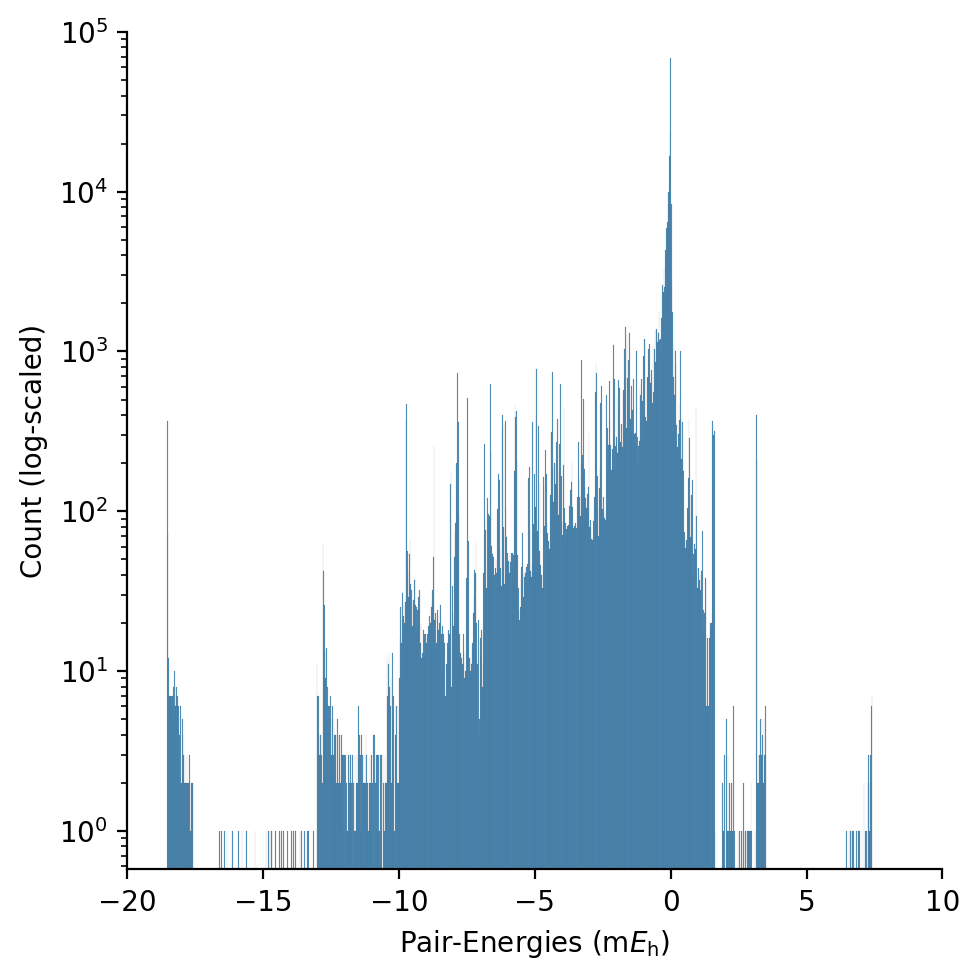

In [19]:
sns.displot(np.hstack([y_train,y_test])*1e3)
plt.yscale('log')
plt.xlim(-20,10)
plt.ylim(0,10**5)
plt.ylabel("Count (log-scaled)")
plt.xlabel('Pair-Energies (m$E_{\mathrm{h}}$)')
plt.tight_layout()
plt.savefig('images/Pair_energies_dist.png',dpi=300,bbox_inches='tight')

In [20]:
train_tss = np.sum((y_train-np.mean(y_train))**2)*1e3

In [21]:
test_tss = np.sum((y_test-np.mean(y_test))**2)*1e3

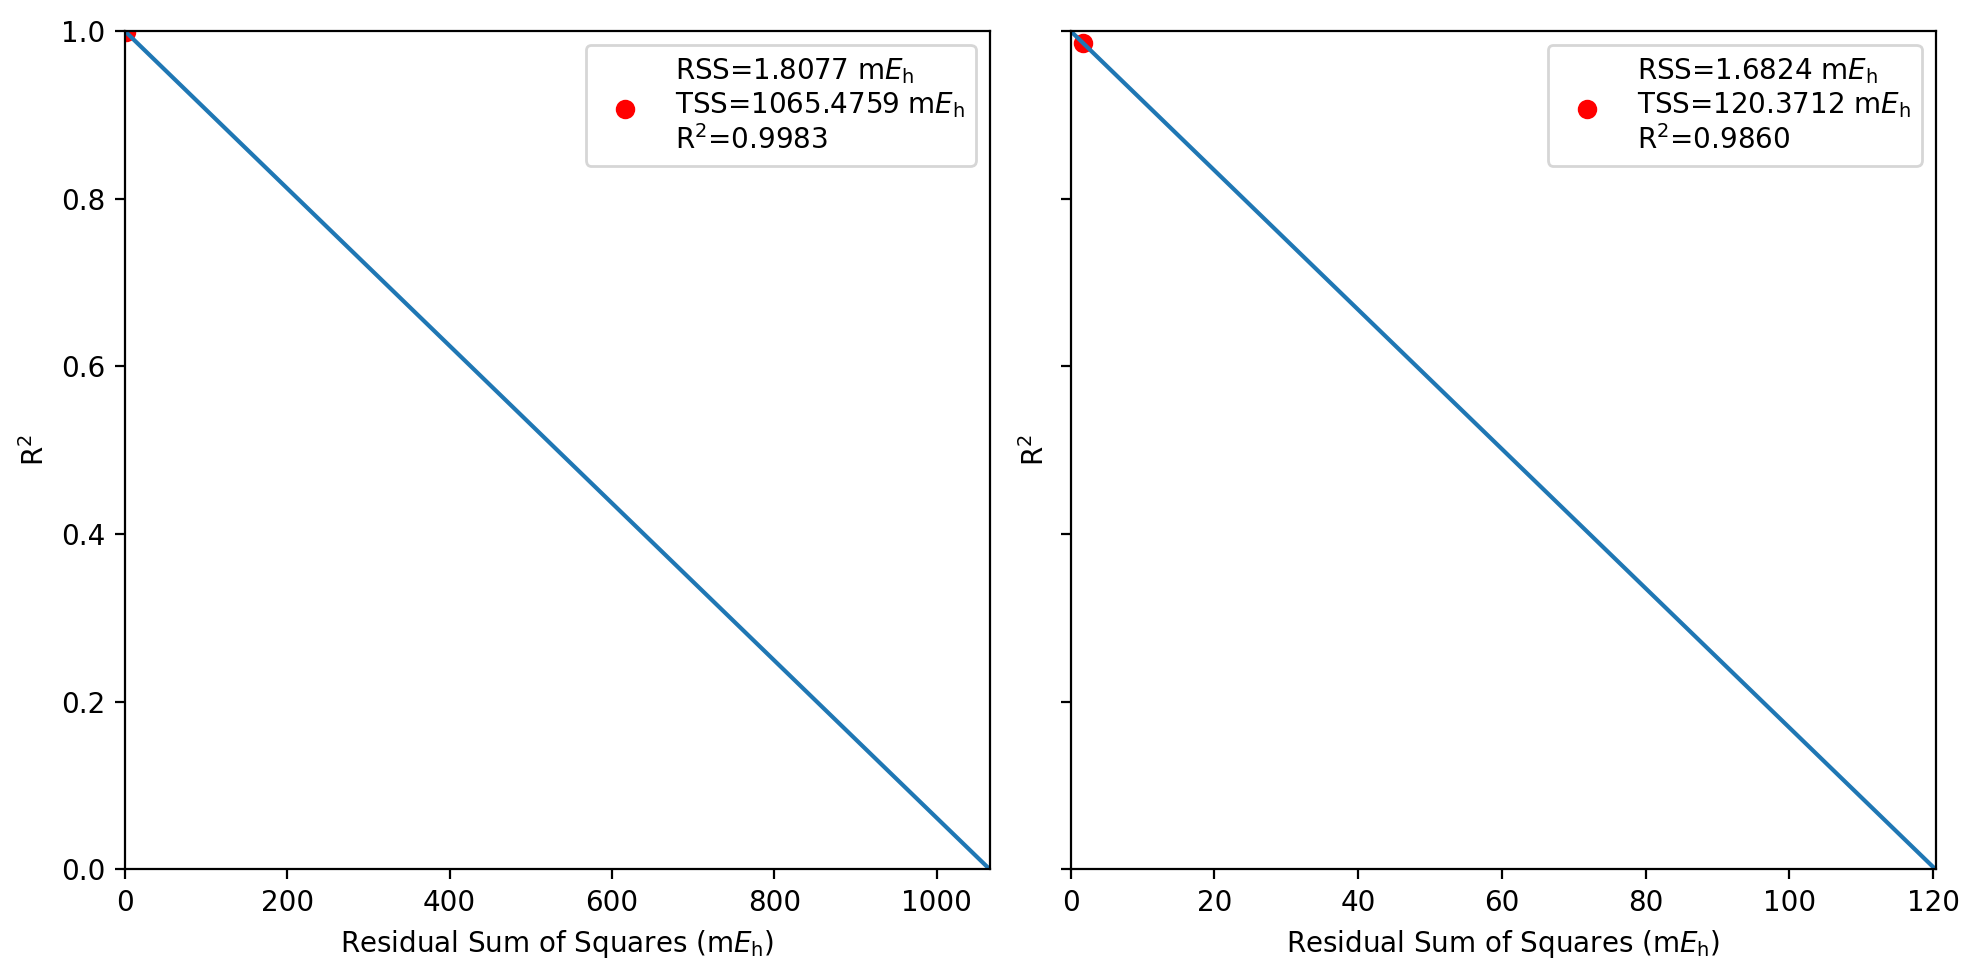

In [22]:
example_train =np.array([(i, 1 - (i / train_tss)) for i in np.linspace(train_tss,0,100)])
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,5))
ax1.plot(*example_train.T)
ax1.scatter(np.sum((y_train-y_pred_train)**2)*1e3,r2_score(y_train,y_pred_train),color='red',label=f"RSS={np.sum((y_train-y_pred_train)**2)*1e3:.4f}"+" m$E_{\mathrm{h}}$\n"+f"TSS={np.sum((y_train-np.mean(y_train))**2)*1e3:.4f}"+" m$E_{\mathrm{h}}$\n"+"R$^{2}$="+f"{r2_score(y_train,y_pred_train):.4f}")
ax1.set_xlabel('Residual Sum of Squares (m$E_{\mathrm{h}}$)')
ax1.set_ylabel('R$^{2}$')
ax1.set_ylim(0,1)
ax1.set_xlim(0,train_tss)
ax1.legend()

example_test =np.array([(i, 1 - (i / test_tss)) for i in np.linspace(test_tss,0,100)])
ax2.plot(*example_test.T)
ax2.scatter(np.sum((y_test-y_pred_test)**2)*1e3,r2_score(y_test,y_pred_test),color='red',label=f"RSS={np.sum((y_test-y_pred_test)**2)*1e3:.4f}"+" m$E_{\mathrm{h}}$\n"+f"TSS={np.sum((y_test-np.mean(y_test))**2)*1e3:.4f}"+" m$E_{\mathrm{h}}$\n"+"R$^{2}$="+f"{r2_score(y_test,y_pred_test):.4f}")
ax2.set_xlabel('Residual Sum of Squares (m$E_{\mathrm{h}}$)')
ax2.set_ylabel('R$^{2}$')
ax2.set_ylim(0,1)
ax2.set_xlim(0,test_tss)
ax2.legend()
plt.tight_layout()
plt.savefig('images/RSS_vs_R2_original.png',dpi=300,bbox_inches='tight')
plt.show()

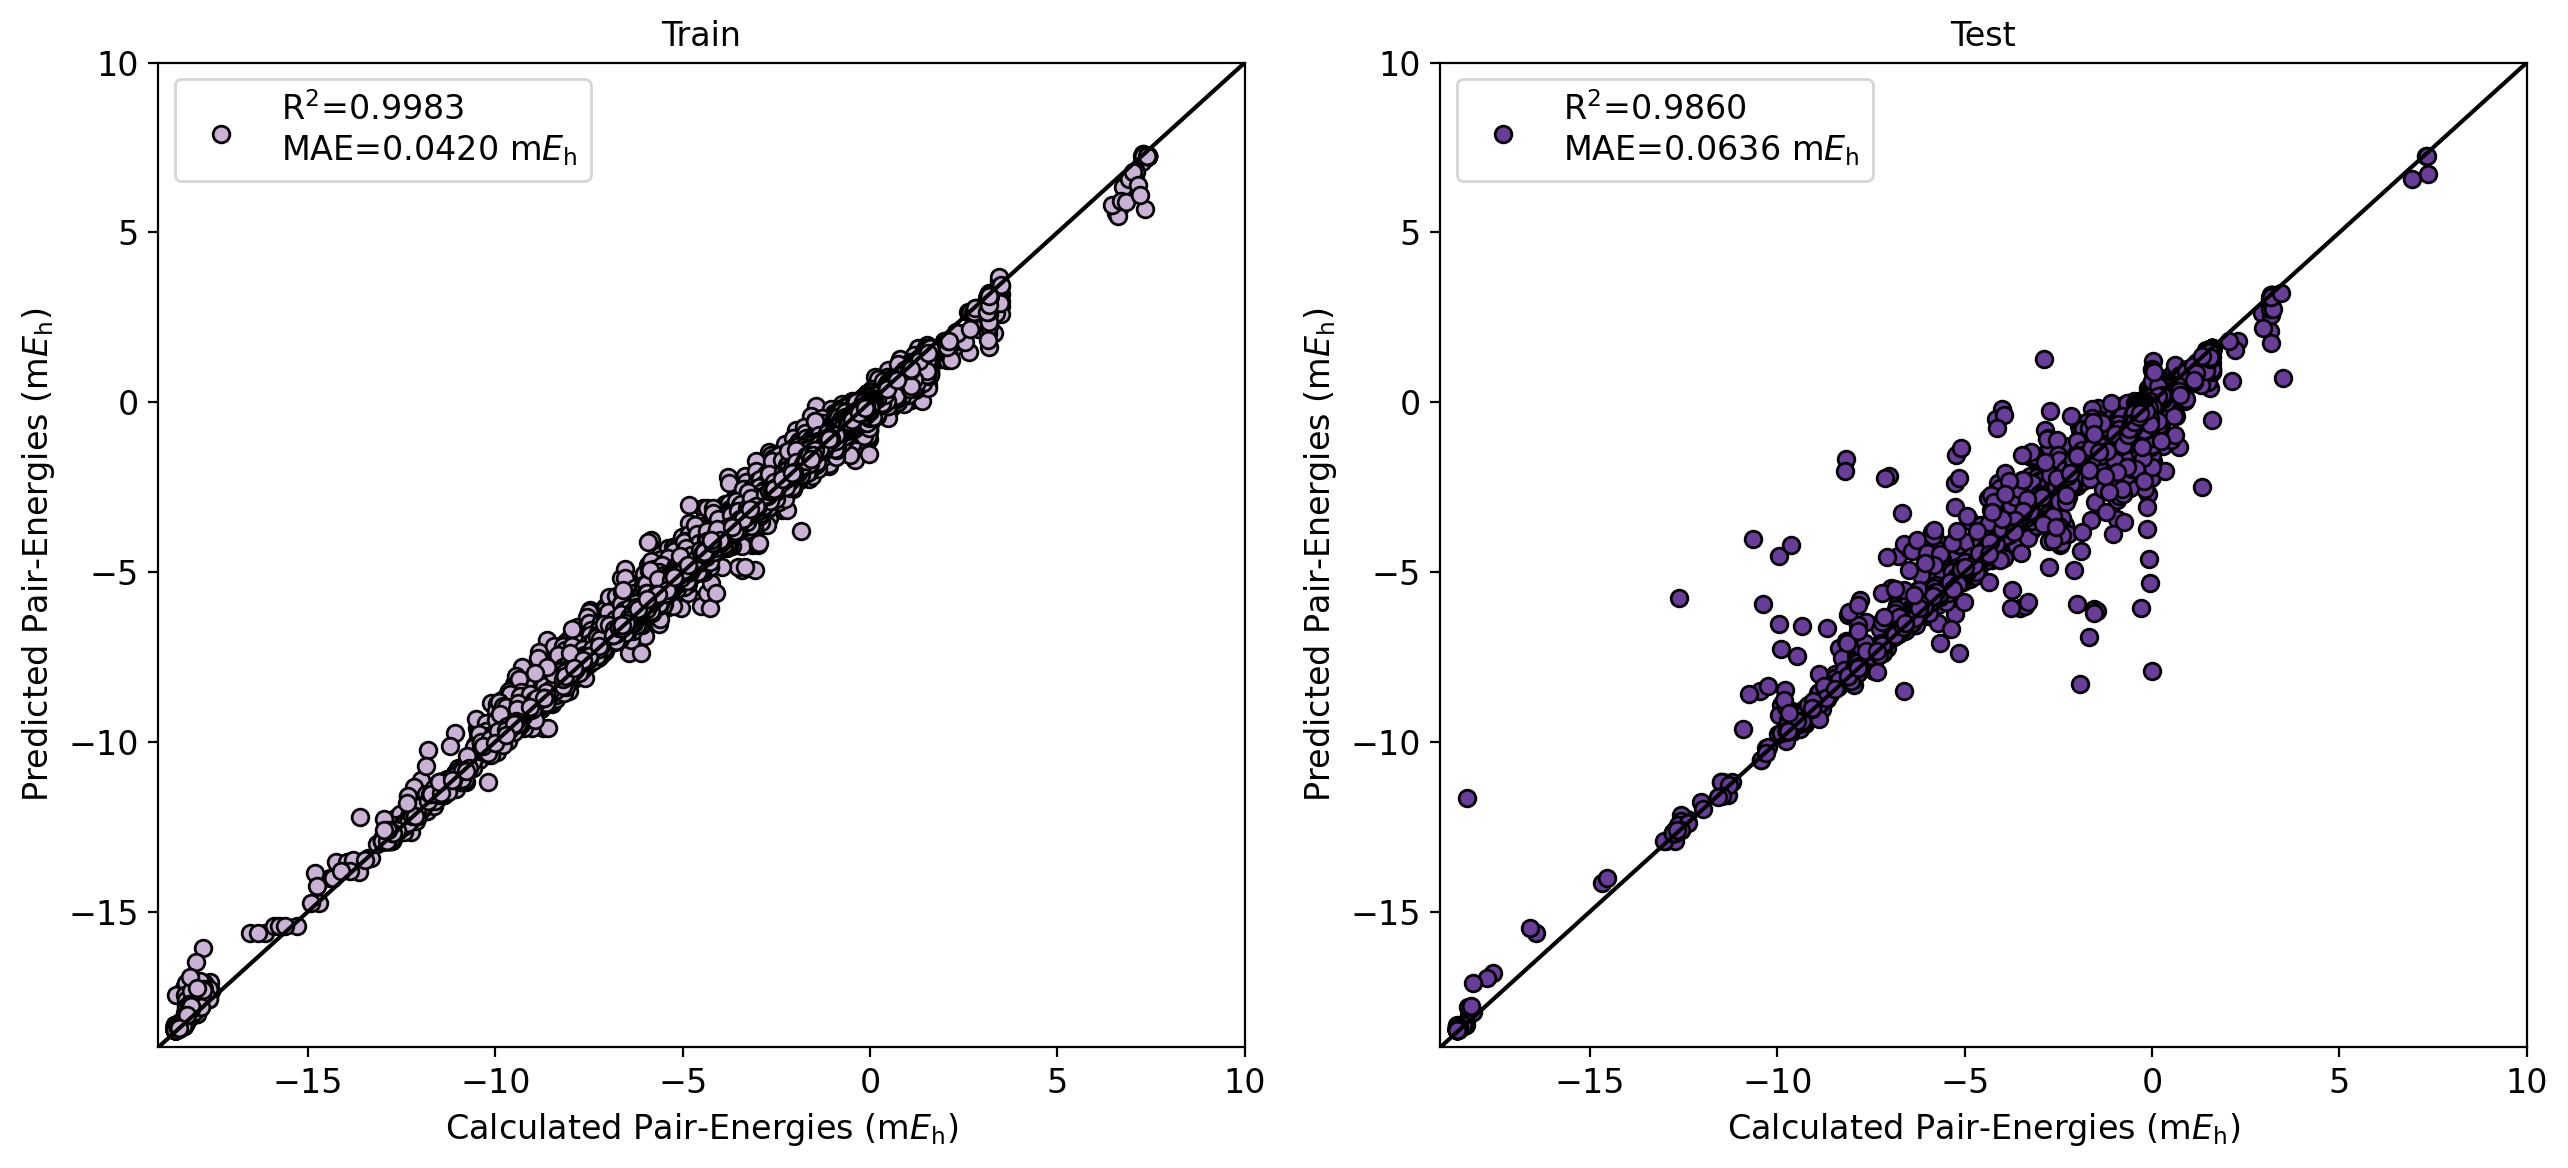

In [23]:
pal = sns.color_palette("Paired")
font=12
plt.rc('font', size=font)          # controls default text sizes
plt.rc('axes', titlesize=font)     # fontsize of the axes title
plt.rc('axes', labelsize=font)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font)    # fontsize of the tick labels
plt.rc('legend', fontsize=font)    # legend fontsize
plt.rc('figure', titlesize=font)  # fontsize of the figure title
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,6))
scale=1e-1
ax1.set_title('Train')
ax1.scatter(1e3*y_train,1e3*y_pred_train,label="R$^{2}$="+f'{r2_score(y_train,y_pred_train):.4f}\nMAE={1e3*mean_absolute_error(y_train,y_pred_train):.4f}'+" m$E_{\mathrm{h}}$",color=pal[8],edgecolors='k')
ax1.plot(np.arange(-1e3,1e3),np.arange(-1e3,1e3),'k-')
LMIN,LMAX = -19, 10
ax1.set_xlim(LMIN,LMAX)
ax1.set_ylim(LMIN,LMAX)
ax1.set_xlabel('Calculated Pair-Energies (m$E_{\mathrm{h}}$)')
ax1.set_ylabel('Predicted Pair-Energies (m$E_{\mathrm{h}}$)')
ax1.legend()


ax2.set_title('Test')
ax2.scatter(1e3*y_test,1e3*y_pred_test,label="R$^{2}$="+f'{r2_score(y_test,y_pred_test):.4f}\nMAE={1e3*mean_absolute_error(y_test,y_pred_test):.4f}'+" m$E_{\mathrm{h}}$",color=pal[9],edgecolors='k')
ax2.plot(np.arange(-1e3,1e3),np.arange(-1e3,1e3),'k-')
ax2.set_xlim(LMIN,LMAX)
ax2.set_ylim(LMIN,LMAX)
ax2.set_xlabel('Calculated Pair-Energies (m$E_{\mathrm{h}}$)')
ax2.set_ylabel('Predicted Pair-Energies (m$E_{\mathrm{h}}$)')
ax2.legend()

plt.tight_layout()
plt.savefig('images/iron_VDZP_parity.png',dpi=300,bbox_inches='tight')
plt.show()

In [24]:
testcntrcvr = 0
recover_test_list = []
recover_test_E2 = []
for j,k,l in recover_test:
    init_test = testcntrcvr
    testcntrcvr+=l
    recover_test_list.append((j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
    recover_test_E2.append((j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))


traincntrcvr = 0
recover_train_list = []
recover_train_E2 = []
for j,k,l in recover_train:
    init_train = traincntrcvr
    traincntrcvr+=l
    recover_train_list.append((j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
    recover_train_E2.append((j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))

In [25]:
traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
#.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
#.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})



traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
traincorrE2['E2']=np.zeros(len(traincorrE2))



for i in traincorrE2.index:
    energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
    traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
    traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
    # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values

traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']

traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)


testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
testcorrE2['E2']=np.zeros(len(testcorrE2))



for i in testcorrE2.index:
    energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
    testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
    testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
    # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values

testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']

testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)

testcorrE2.reset_index(inplace=True)
traincorrE2.reset_index(inplace=True)

In [26]:
traincaspt2melt = traincorrE2.reset_index().melt(id_vars=['Radius ($\AA$)'], value_vars=['E$_{\text{CASPT2}}^{\text{Calculated}}$','E$_{\text{CASPT2}}^{\text{Predicted}}$']).astype({'Radius ($\AA$)':float,'value':float})
testcaspt2melt = testcorrE2.reset_index().melt(id_vars=['Radius ($\AA$)'], value_vars=['E$_{\text{CASPT2}}^{\text{Calculated}}$','E$_{\text{CASPT2}}^{\text{Predicted}}$']).astype({'Radius ($\AA$)':float,'value':float})

In [27]:
trueE2=pd.concat([traincorrE2.reset_index(),testcorrE2.reset_index()]).astype({'Radius ($\AA$)':float,'E$_{\text{CASPT2}}^{\text{Calculated}}$':float})

In [28]:
testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'].min()

np.float64(-1345.88550953)

In [29]:
mean_absolute_error(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(1.4848340026945615)

In [30]:
mean_absolute_error(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(0.9783963572039688)

In [31]:
pairedcp=sns.color_palette('Paired')

In [32]:
mean_absolute_error(traincorrE2['E$_{2}^{\text{Calculated}}$'],traincorrE2['E$_{2}^{\text{Predicted}}$'])*1e3

np.float64(0.9784021600909062)

In [33]:
mean_absolute_error(testcorrE2['E$_{2}^{\text{Calculated}}$'],testcorrE2['E$_{2}^{\text{Predicted}}$'])*1e3

np.float64(1.484922242732971)

In [34]:
allcorr=pd.concat([traincorrE2,testcorrE2])

-0.41976744 -0.42019991151165514
-0.37312812 -0.3805382433705244
-1345.8893834114167 -1345.88755975
-1345.805316523711 -1345.81809328


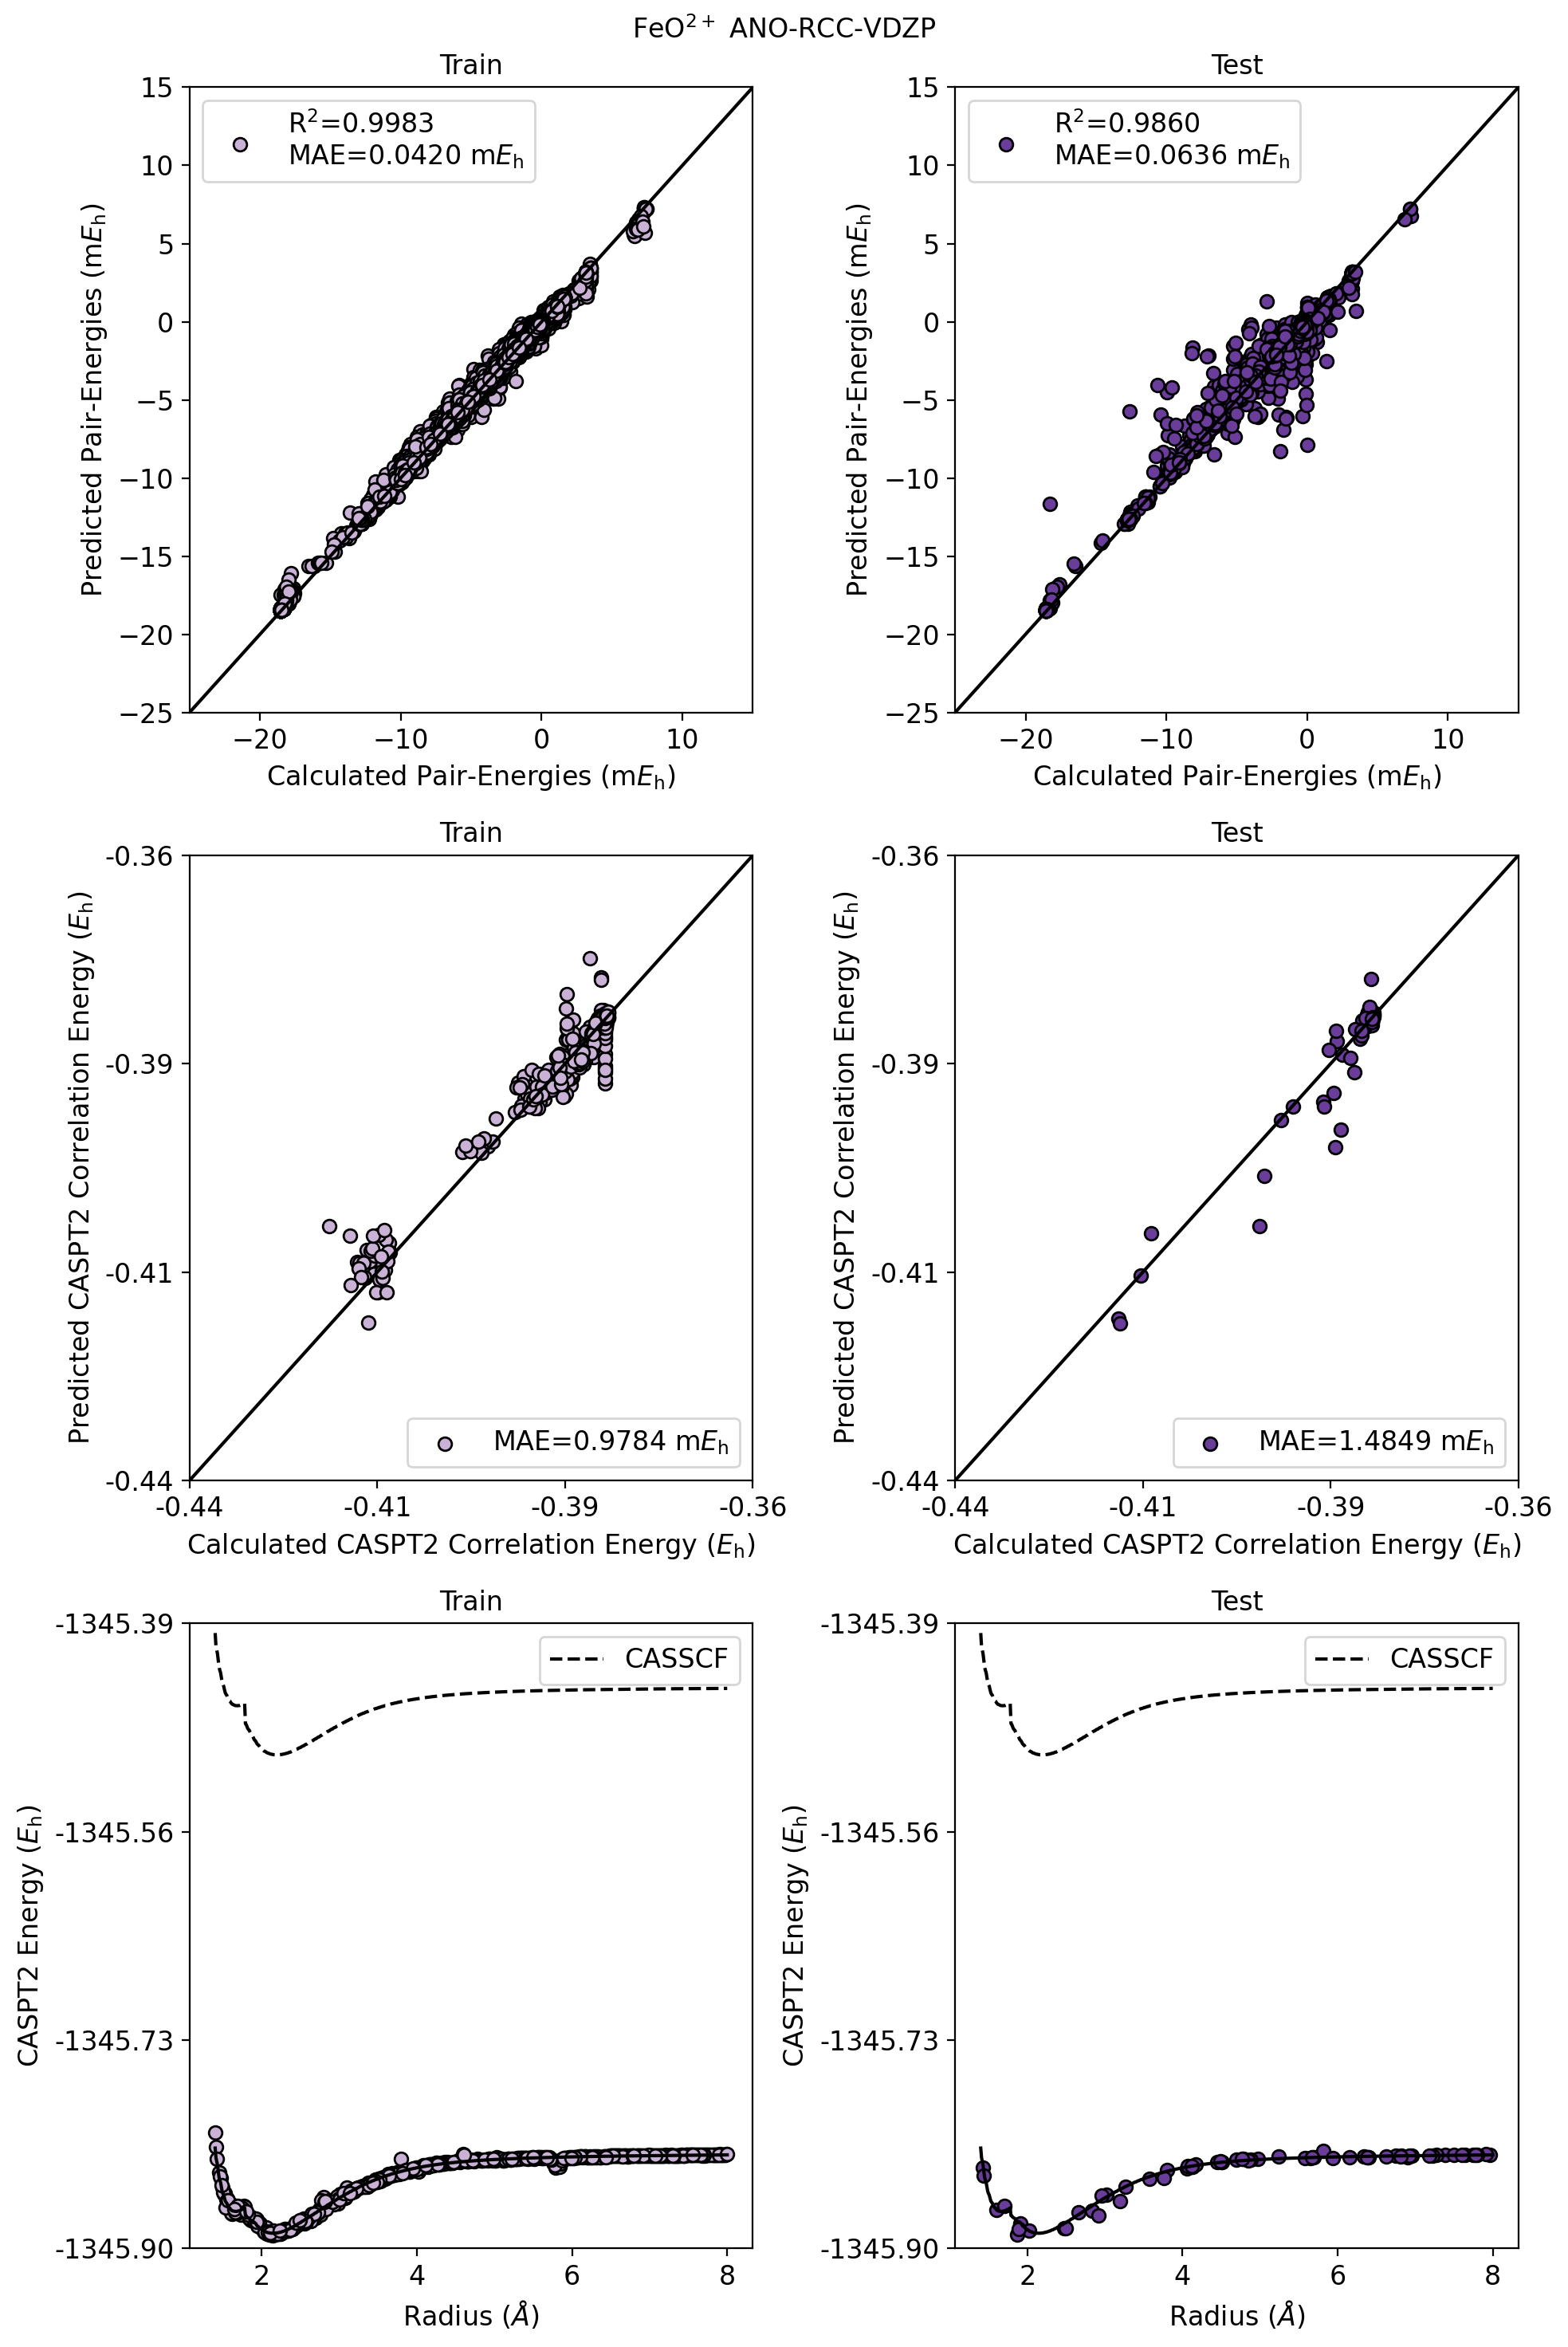

In [35]:
traincorrerr = {}

fig,((ax1,ax2),(ax3,ax4),(ax5,ax6))=plt.subplots(3,2,figsize=(10,15),sharey=False)


scale=1e-1
ax1.set_title('Train')
ax1.scatter(1e3*y_train,1e3*y_pred_train,label="R$^{2}$="+f'{r2_score(y_train,y_pred_train):.4f}\nMAE={1e3*mean_absolute_error(y_train,y_pred_train):.4f}'+" m$E_{\mathrm{h}}$",color=pal[8],edgecolors='k')
ax1.plot(np.arange(-1e3,1e3),np.arange(-1e3,1e3),'k-')
LMIN,LMAX = -25, 15
ax1.set_xlim(LMIN,LMAX)
ax1.set_ylim(LMIN,LMAX)
ax1.set_xlabel('Calculated Pair-Energies (m$E_{\mathrm{h}}$)')
ax1.set_ylabel('Predicted Pair-Energies (m$E_{\mathrm{h}}$)')
ax1.legend()


ax2.set_title('Test')
ax2.scatter(1e3*y_test,1e3*y_pred_test,label="R$^{2}$="+f'{r2_score(y_test,y_pred_test):.4f}\nMAE={1e3*mean_absolute_error(y_test,y_pred_test):.4f}'+" m$E_{\mathrm{h}}$",color=pal[9],edgecolors='k')
ax2.plot(np.arange(-1e3,1e3),np.arange(-1e3,1e3),'k-')
ax2.set_xlim(LMIN,LMAX)
ax2.set_ylim(LMIN,LMAX)
ax2.set_xlabel('Calculated Pair-Energies (m$E_{\mathrm{h}}$)')
ax2.set_ylabel('Predicted Pair-Energies (m$E_{\mathrm{h}}$)')
ax2.legend()


pred_train,true_train = traincorrE2['E$_{2}^{\text{Predicted}}$'],traincorrE2['E$_{2}^{\text{Calculated}}$']
pred_test,true_test = testcorrE2['E$_{2}^{\text{Predicted}}$'],testcorrE2['E$_{2}^{\text{Calculated}}$']
testrad = testcorrE2['Radius ($\AA$)']    
train_r2_corr = r2_score(true_train,pred_train)
test_r2_corr = r2_score(true_test,pred_test)
test_mae_corr = 1e3*mean_absolute_error(true_test,pred_test)
train_mae_corr = 1e3*mean_absolute_error(true_train,pred_train)
print(pred_train.min(),true_train.min())
print(pred_train.max(),true_train.max())
traincorrerr = {"r2_train":train_r2_corr,"r2_test":test_r2_corr,"mae_train":train_mae_corr,"mae_test":test_mae_corr}
trainrad = traincorrE2['Radius ($\AA$)']
# ax3.scatter(true_train,pred_train,label='R$^{2}$='+f'{train_r2_corr:.4f}\nMAE={train_mae_corr:.4f}'+" m$E_{\mathrm{h}}$",color=pairedcp[8],edgecolors='k')
ax3.scatter(true_train,pred_train,label=f'MAE={train_mae_corr:.4f}'+" m$E_{\mathrm{h}}$",color=pairedcp[8],edgecolors='k')

ax3.set_xlabel('Calculated CASPT2 Correlation Energy ($E_{\mathrm{h}}$)')
ax3.set_ylabel('Predicted CASPT2 Correlation Energy ($E_{\mathrm{h}}$)')
ax3.set_title('Train')
ax3.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax3.legend(loc=4)


ax4.scatter(true_test,pred_test,label=f'MAE={test_mae_corr:.4f}'+" m$E_{\mathrm{h}}$",color=pairedcp[9],edgecolors='k')
# ax2.plot(true_test,true_test,'k')
ax4.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax4.set_xlabel('Calculated CASPT2 Correlation Energy ($E_{\mathrm{h}}$)')
ax4.set_ylabel('Predicted CASPT2 Correlation Energy ($E_{\mathrm{h}}$)')
ax4.set_title('Test')    
ax4.legend(loc=4)

bottom, top = -0.44, -0.36
ax3.set_xlim(bottom, top)
ax3.set_ylim(bottom, top)
ax4.set_xlim(bottom, top)
ax4.set_ylim(bottom, top)
ax3.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])
ax3.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
ax4.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
ax4.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    

pred_train,true_train = traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$']
pred_test,true_test = testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$']
testrad = testcorrE2['Radius ($\AA$)']    

print(pred_train.min(),true_train.min())
print(pred_train.max(),true_train.max())
traincorrerr = {"r2_train":train_r2_corr,"r2_test":test_r2_corr,"mae_train":train_mae_corr,"mae_test":test_mae_corr}
trainrad = traincorrE2['Radius ($\AA$)']
ax5.scatter(np.array(trainrad,dtype=float),pred_train,color=pairedcp[8],edgecolors='k')
ax5.plot(allcorr.sort_values(by='Radius ($\AA$)')['Radius ($\AA$)'].astype(float),allcorr.sort_values(by='Radius ($\AA$)')['E$_{\text{CASPT2}}^{\text{Calculated}}$'].astype(float),'k')
ax5.plot(allcorr.sort_values(by='Radius ($\AA$)')['Radius ($\AA$)'].astype(float),allcorr.sort_values(by='Radius ($\AA$)')['E$_{\text{CASSCF}}^{\text{Calculated}}$'].astype(float),'k--',label='CASSCF')
ax5.set_xlabel('Radius ($\AA$)')
ax5.set_ylabel('CASPT2 Energy ($E_{\mathrm{h}}$)')
ax5.set_title('Train')
ax5.legend()

ax6.scatter(np.array(testrad,dtype=float),pred_test,color=pairedcp[9],edgecolors='k')
ax6.plot(trueE2.sort_values(by='Radius ($\AA$)')['Radius ($\AA$)'].astype(float),trueE2.sort_values(by='Radius ($\AA$)')['E$_{\text{CASPT2}}^{\text{Calculated}}$'].astype(float),'k')
ax6.plot(allcorr.sort_values(by='Radius ($\AA$)')['Radius ($\AA$)'].astype(float),allcorr.sort_values(by='Radius ($\AA$)')['E$_{\text{CASSCF}}^{\text{Calculated}}$'].astype(float),'k--',label='CASSCF')
ax6.set_xlabel('Radius ($\AA$)')
ax6.set_ylabel('CASPT2 Energy ($E_{\mathrm{h}}$)')
ax6.set_title('Test') 
ax6.legend()

minpt2, maxpt2= pd.concat([true_train,true_test]).min(), pd.concat([true_train,true_test]).max()
pct=0.1
bufferbot, buffertop = minpt2*pct, maxpt2*pct




bottom, top = -1345.9, -1345.39
ax5.set_ylim(bottom,top)
ax5.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)]) 
ax6.set_ylim(bottom,top)
ax6.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)]) 

fig.suptitle("FeO$^{2+}$ ANO-RCC-VDZP")

plt.subplots_adjust(wspace=0.05)
plt.tight_layout()
plt.savefig(f'images/iron_VDZPCASPT2.png',dpi=300,bbox_inches='tight')
plt.show()    

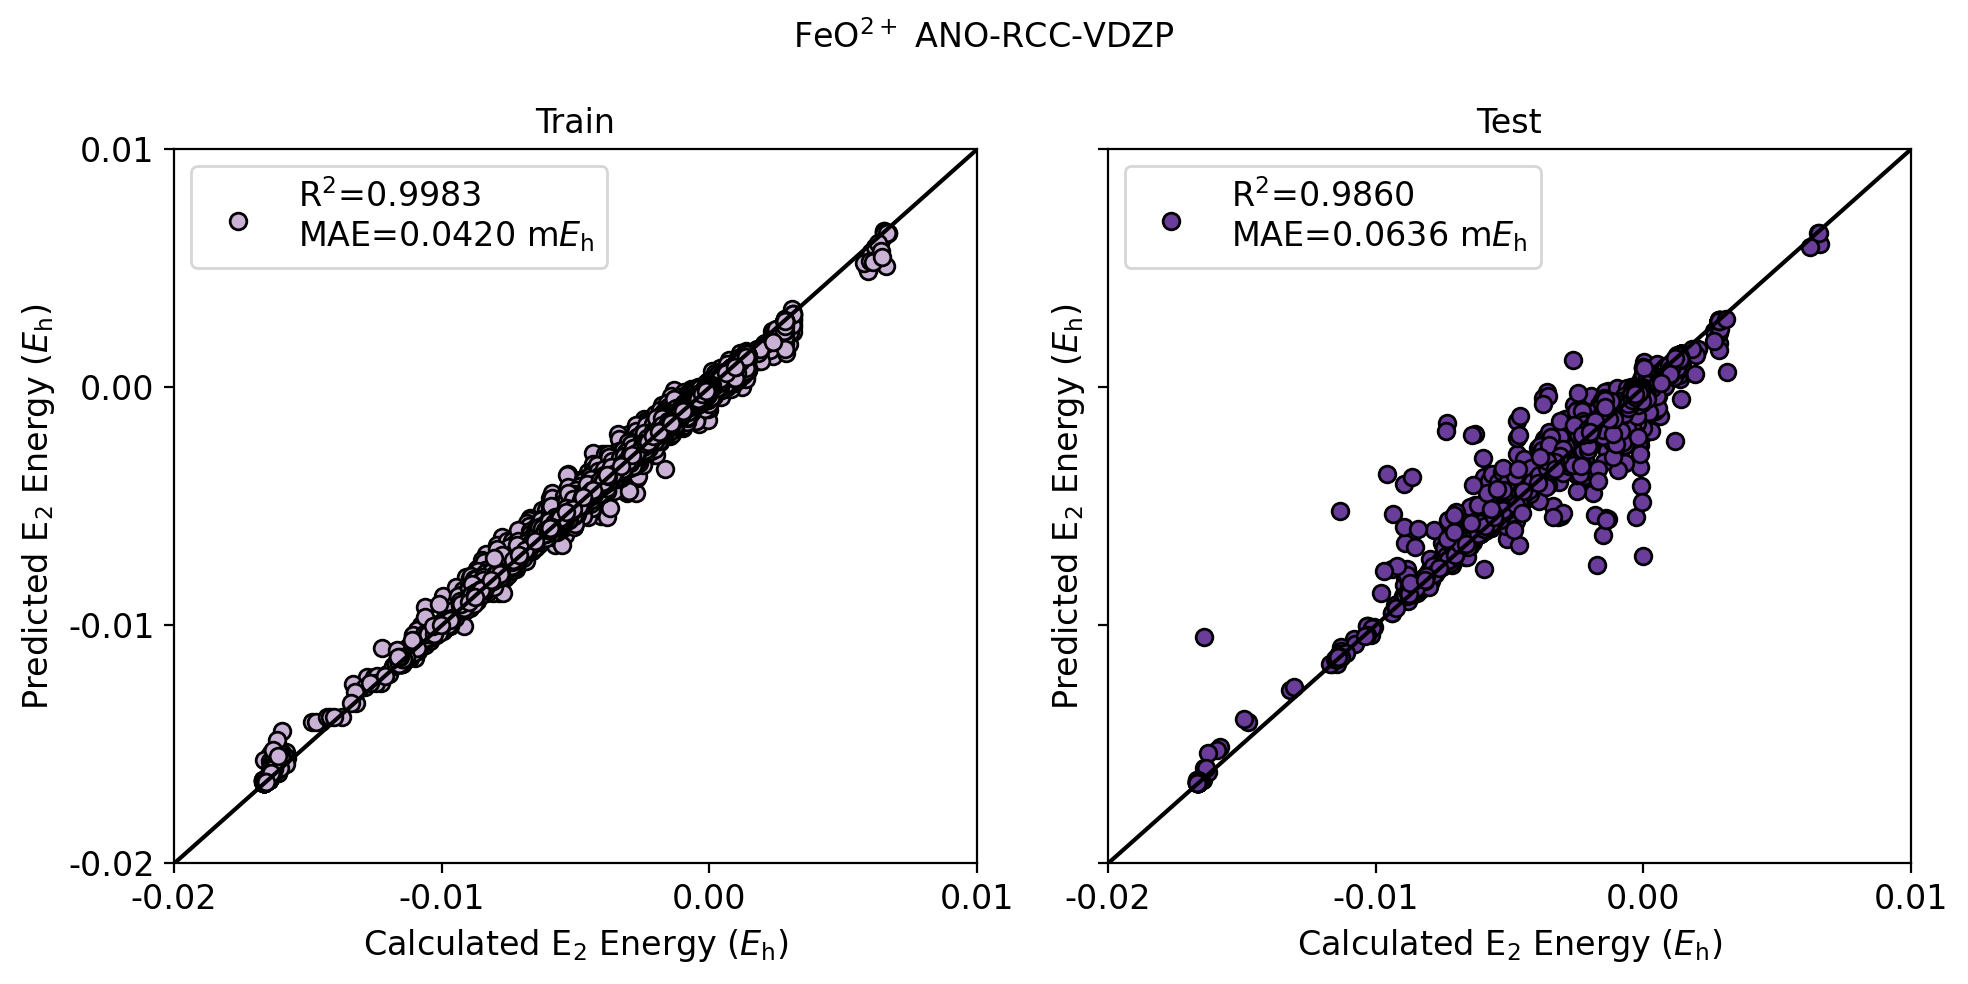

In [36]:
trainpairdf = pd.DataFrame(recover_train_list)
testpairdf = pd.DataFrame(recover_test_list)
pairerr={}

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)

truetrainpair, predtrainpair = np.hstack(trainpairdf[1]),np.hstack(trainpairdf[2])
train_r2_pair = r2_score(truetrainpair, predtrainpair)
train_mae_pair = 1e3*mean_absolute_error(truetrainpair, predtrainpair)
ax1.scatter(truetrainpair, predtrainpair,label='R$^{2}$='+f'{train_r2_pair:.4f}\nMAE={train_mae_pair:.4f}'+" m$E_{\mathrm{h}}$",color=pairedcp[8],edgecolors='k')
ax1.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax1.set_xlabel('Calculated E$_2$ Energy ($E_{\mathrm{h}}$)')
ax1.set_ylabel('Predicted E$_2$ Energy ($E_{\mathrm{h}}$)')
ax1.set_title('Train')    
ax1.legend()  

truetestpair, predtestpair = np.hstack(testpairdf[1]),np.hstack(testpairdf[2])
test_r2_pair = r2_score(truetestpair, predtestpair)
test_mae_pair = 1e3*mean_absolute_error(truetestpair, predtestpair)
ax2.scatter(truetestpair, predtestpair,label='R$^{2}$='+f'{test_r2_pair:.4f}\nMAE={test_mae_pair:.4f}'+" m$E_{\mathrm{h}}$",color=pairedcp[9],edgecolors='k')
ax2.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax2.set_xlabel('Calculated E$_2$ Energy ($E_{\mathrm{h}}$)')
ax2.set_ylabel('Predicted E$_2$ Energy ($E_{\mathrm{h}}$)')
ax2.set_title('Test')    
ax2.legend()    

mincorr, maxcorr= np.hstack([truetrainpair,truetestpair]).min(), np.hstack([truetrainpair,truetestpair]).max()
pct=0.50
bufferbot, buffertop = mincorr*pct, maxcorr*pct

# if 'H' in n:
bottom, top = mincorr-buffertop, maxcorr+buffertop

# else:
#     bottom, top = mincorr+-0.1, maxcorr+0.05

ax1.set_xlim(bottom,top)
ax1.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])
ax1.set_ylim(bottom,top)
ax1.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
ax2.set_xlim(bottom,top)
ax2.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
ax2.set_ylim(bottom,top)
ax2.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    

fig.suptitle("FeO$^{2+}$ ANO-RCC-VDZP")
plt.tight_layout()
plt.savefig(f'images/iron_VDZPE2.png',dpi=300,bbox_inches='tight')    
plt.show()
pairerr = {"r2_train":train_r2_pair,"r2_test":test_r2_pair,"mae_train":train_mae_pair,"mae_test":test_mae_pair}

In [37]:
stackeddata ={'Pair-Energies':{'Train':mean_absolute_error(truetrainpair, predtrainpair)*1e3,'Test':mean_absolute_error(truetestpair, predtestpair)*1e3},
"Correlation Energies":{'Train':mean_absolute_error(true_train,pred_train)*1e3,'Test':mean_absolute_error(pred_test,true_test)*1e3}}
# pd.DataFrame(stackeddata).to_excel("MAE_stacked.xlsx")

In [38]:
# meltcorrerr = pd.DataFrame.from_dict(traincorrerr).loc[['mae_train','mae_test']].T.rename(columns={'mae_train':'Train','mae_test':'Test'}).reset_index().melt(id_vars=['index'], value_vars=['Train','Test'])
# meltpairerr = pd.DataFrame.from_dict(pairerr).loc[['mae_train','mae_test']].T.rename(columns={'mae_train':'Train','mae_test':'Test'}).reset_index().melt(id_vars=['index'], value_vars=['Train','Test'])
# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)
# sns.barplot(data=meltpairerr,x='index',y='value',hue='variable',palette=pairedcp[4:6],ax=ax1)
# ax1.set_ylabel('Mean Absolute Error (m$E_{\mathrm{h}}$)')
# ax1.set_xlabel('Structures')
# ax1.set_title('Pair-Energies')
# ax1.set_ylim(0,2.5)
# sns.barplot(data=meltcorrerr,x='index',y='value',hue='variable',palette=pairedcp[4:6],ax=ax2)
# # ax2.set_ylabel('Mean Absolute Error (m$E_{\mathrm{h}}$)')
# ax2.set_ylabel('')
# ax2.set_xlabel('Structures')
# ax2.set_title('Correlation Energies')

# plt.tight_layout()
# plt.savefig('images/MAE_bar.png',dpi=300,bbox_inches='tight')
# plt.show()

In [39]:
# import shap
# explainer = shap.Explainer(model.predict, X_test)
# shap_values = explainer(X_test)

# dffeat=pd.DataFrame(shap_values.abs.values.mean(axis=0),index=train_df.drop(columns=['Pair_Energies']).columns,columns=['shap']).rename(index={'1':'$\mathbf{b}$'}).reset_index().rename(columns={'index':'feat'}).sort_index().sort_values(by=['shap','feat'],ascending=False)
# # dffeat['rename']=len(dffeat)*[1]


# with open('iron_VDZP_feature_names.txt','w') as f:
#     for i in dffeat['feat'].values:
#         f.write(i+'\n')

# dffeat.to_excel('iron_VDZP_SHAP.xlsx')
dffeat = pd.read_excel('iron_VDZP_SHAP.xlsx')

0 [0, 35]
1 [35, 70]
2 [70, 105]


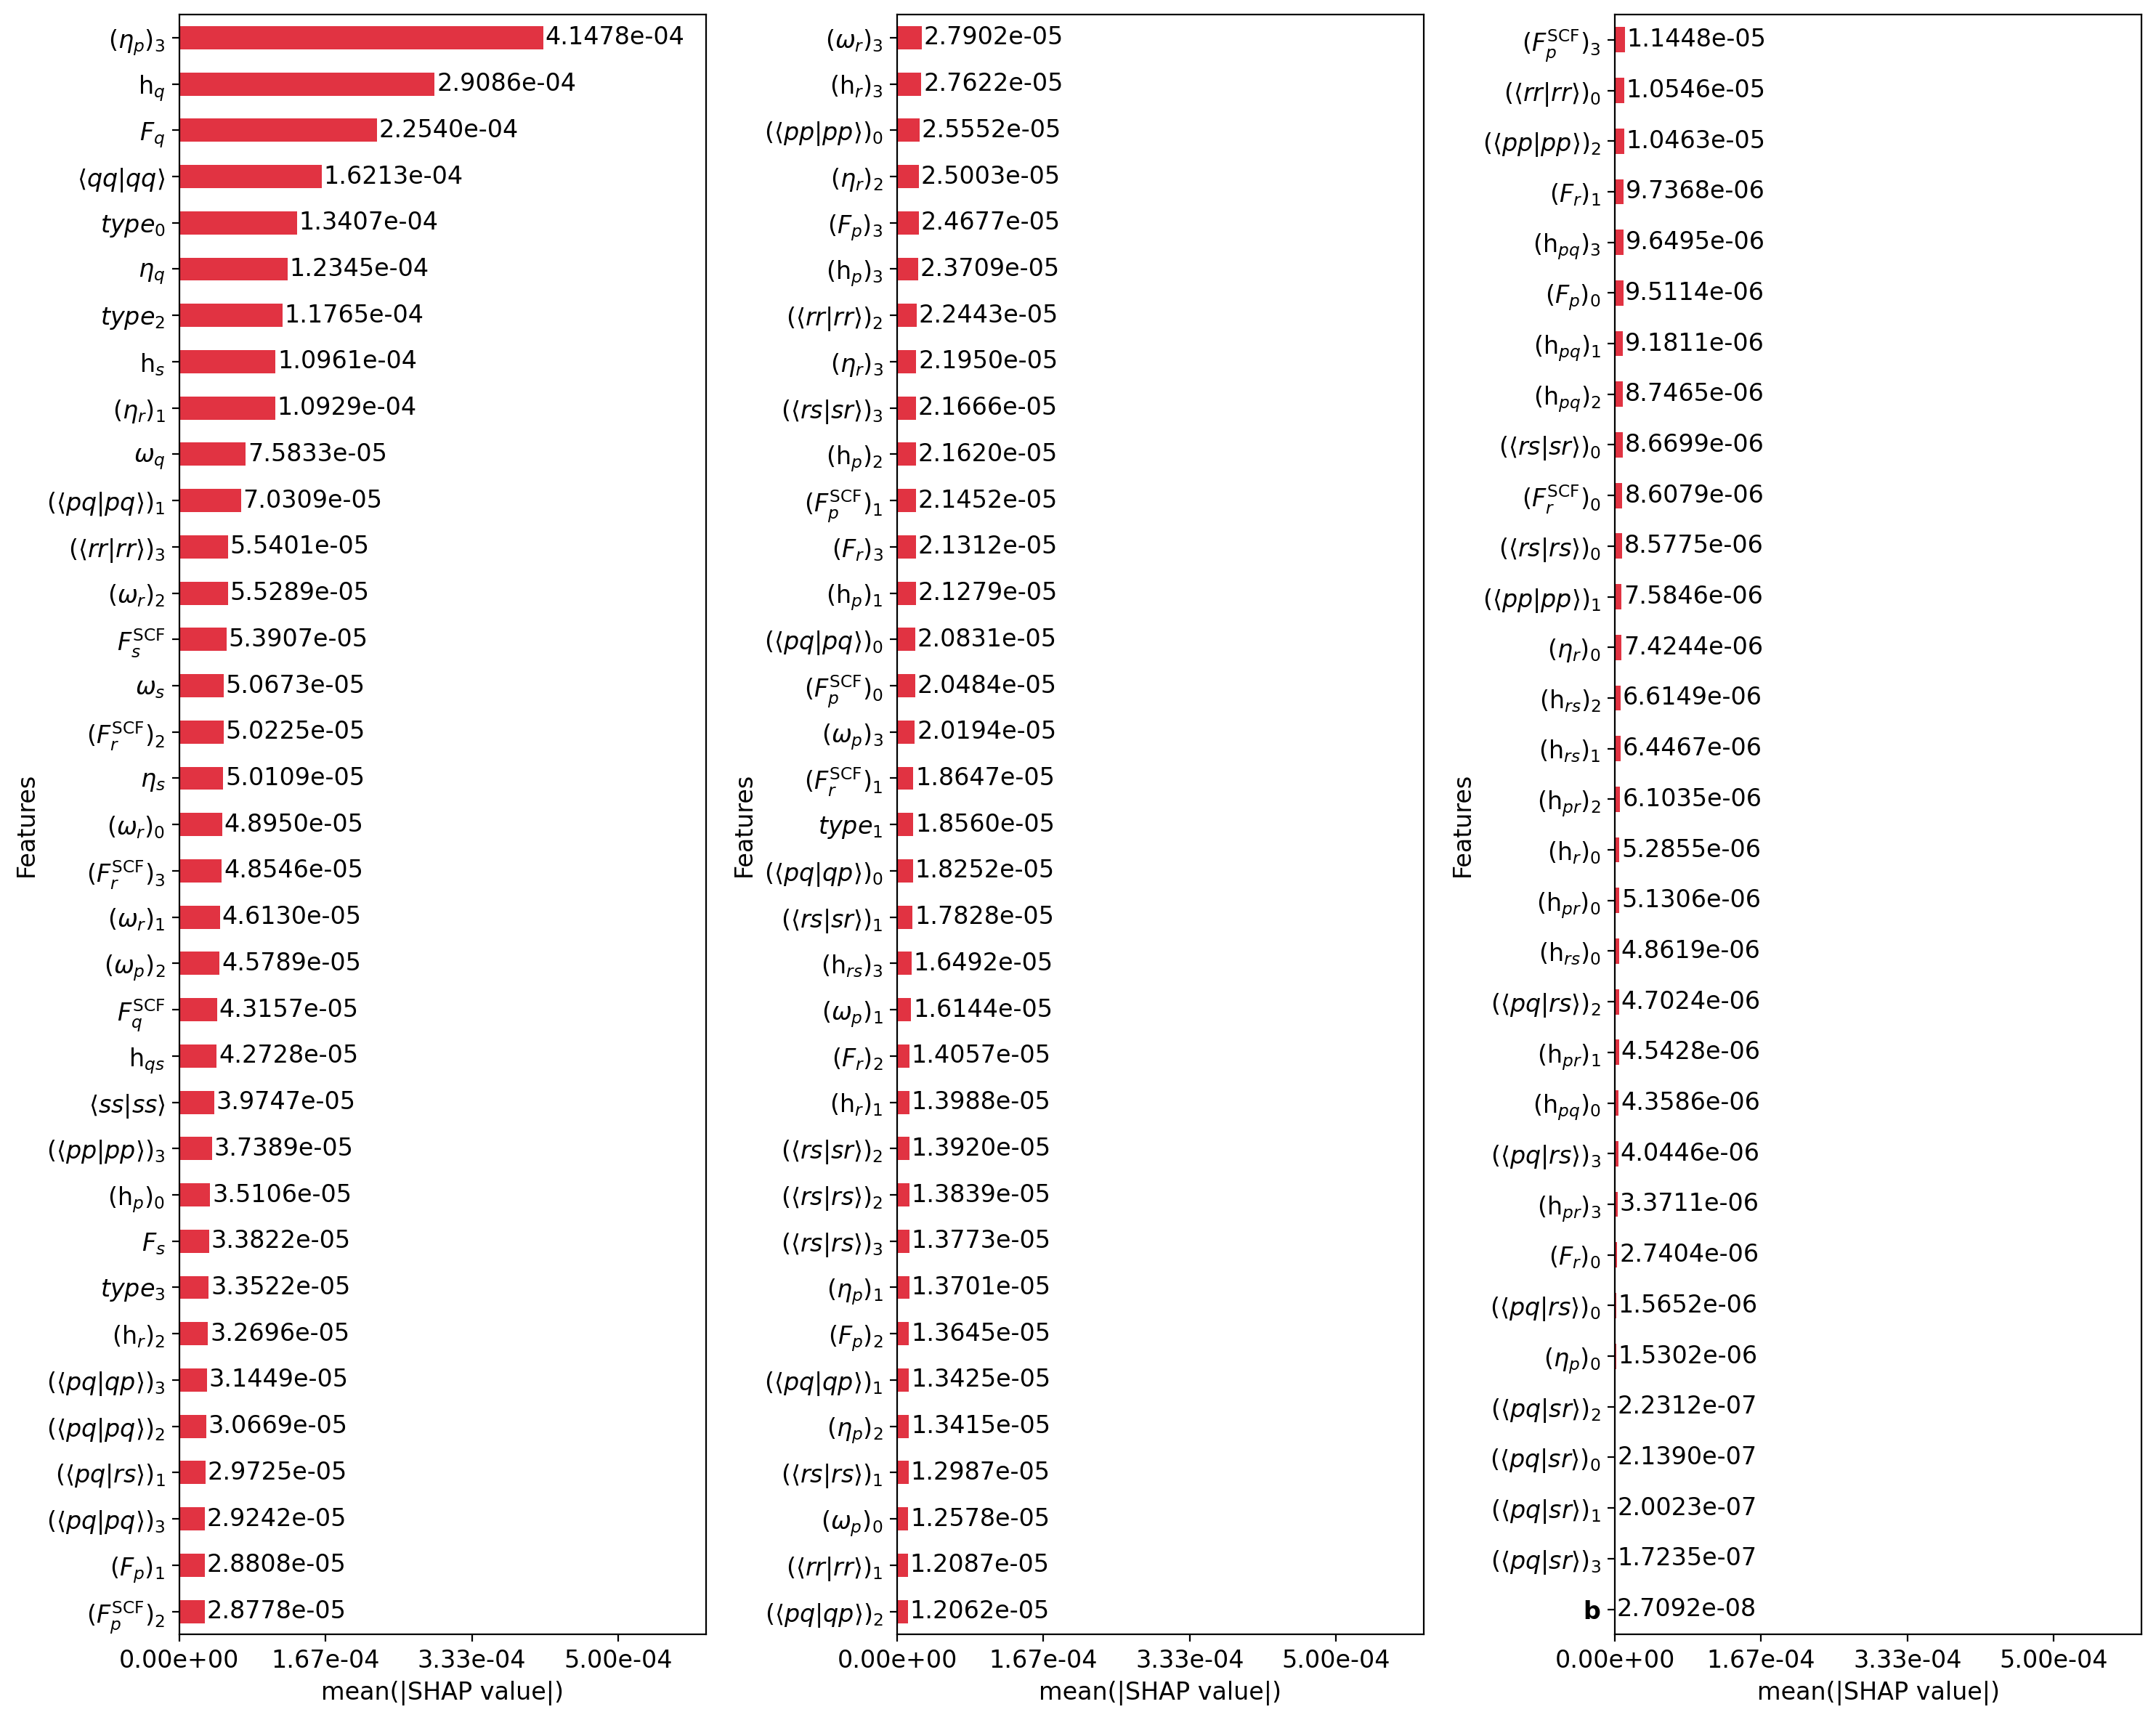

In [40]:
color_map=sns.color_palette('rocket',6)
fontsize = 12
fig, ax = plt.subplots(1,3,figsize=(15,12))
for idx, i in enumerate([[ 0,  35], [35,  70], [70, 105]]):
    print(idx,i)
    feat_1 = dffeat.iloc[i[0]:i[1]]
    ax[idx]=feat_1.sort_values(by=['shap','feat']).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax[idx])
    ax[idx].bar_label(ax[idx].containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
    ax[idx].set_xlim(0,6e-4)
    ax[idx].set_xticks(np.linspace(0,5e-4,4),[f"{i:.2e}" for i in np.linspace(0,5e-4,4)])
    ax[idx].set_ylabel('Features',fontsize=fontsize)
    ax[idx].set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

fig.subplots_adjust(wspace=0, hspace=0)

plt.tight_layout()
plt.savefig('images/iron_VDZP_shap_bar.png',dpi=300, bbox_inches='tight')
plt.show()

In [41]:
dffeat.sort_values(by='shap').iloc[-10:]['feat'].to_list()

['$\\omega_{q}$',
 '$(\\eta_{r})_{1}$',
 'h$_{s}$',
 '$type_2$',
 '$\\eta_{q}$',
 '$type_0$',
 '$\\langle qq \\vert qq \\rangle$',
 '$F_{q}$',
 'h$_{q}$',
 '$(\\eta_{p})_{3}$']

In [42]:
dffeat.sort_values(by='shap').iloc[0:10]['feat'].to_list()

['$\\mathbf{b}$',
 '$(\\langle pq \\vert sr \\rangle)_{3}$',
 '$(\\langle pq \\vert sr \\rangle)_{1}$',
 '$(\\langle pq \\vert sr \\rangle)_{0}$',
 '$(\\langle pq \\vert sr \\rangle)_{2}$',
 '$(\\eta_{p})_{0}$',
 '$(\\langle pq \\vert rs \\rangle)_{0}$',
 '$(F_{r})_{0}$',
 '(h$_{pr}$)$_{3}$',
 '$(\\langle pq \\vert rs \\rangle)_{3}$']

/tmp/ipykernel_11493/928985687.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


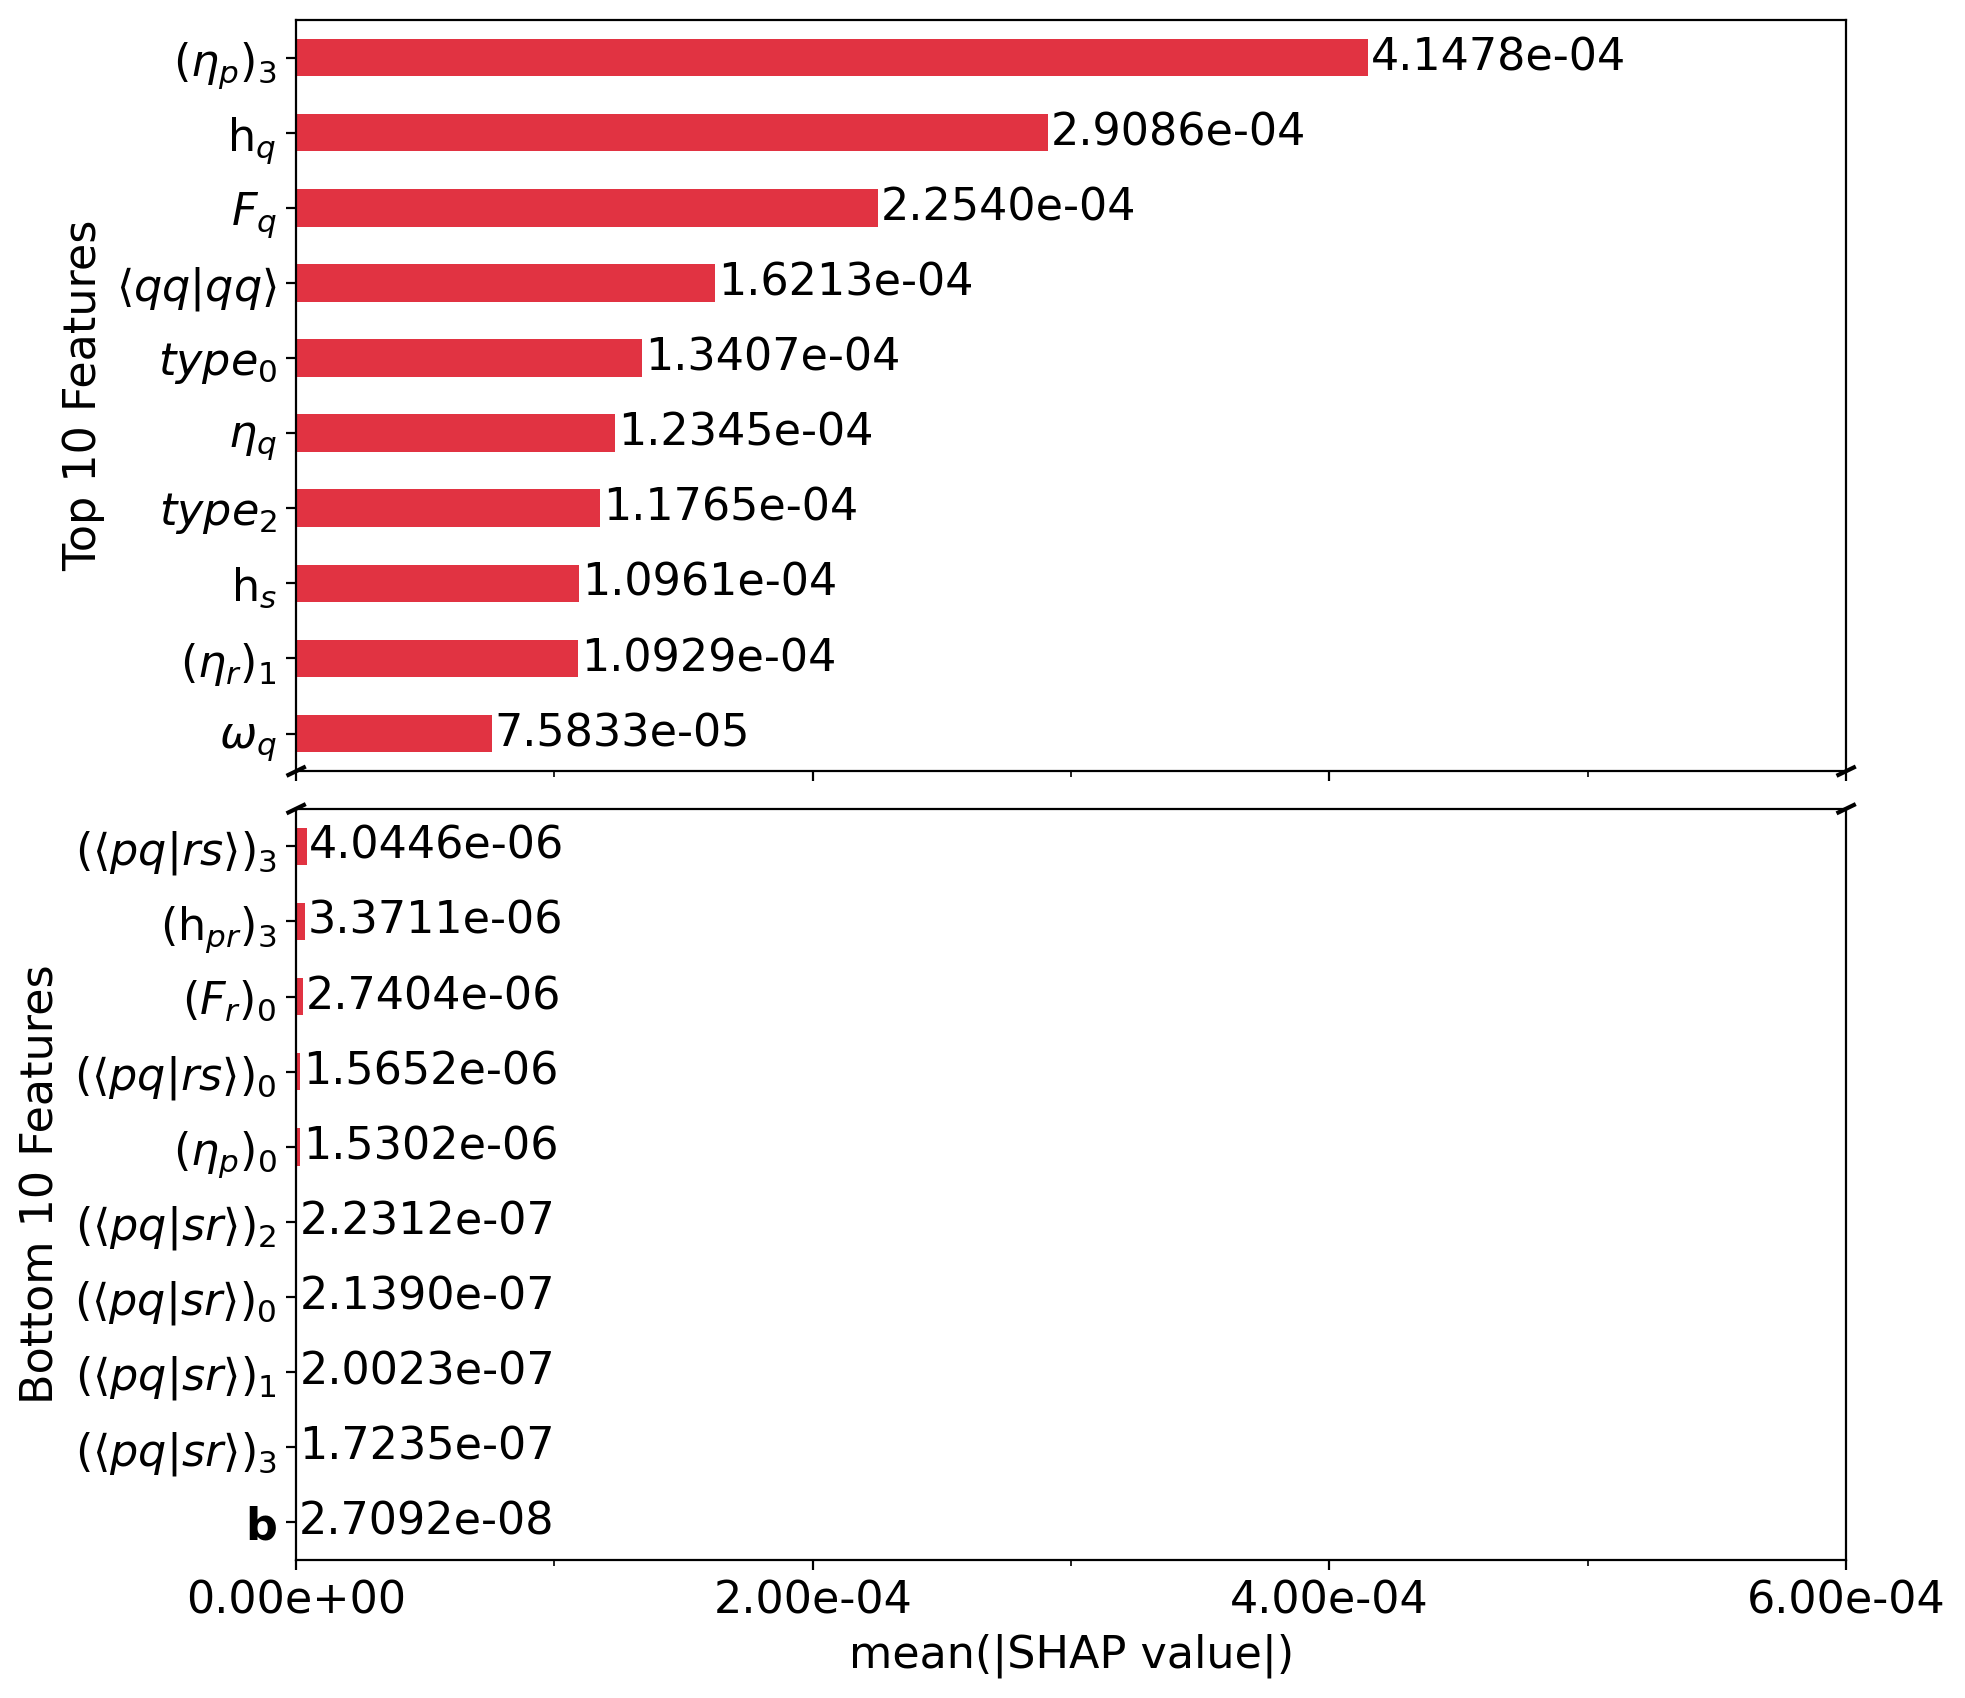

In [43]:
# fig, ax = plt.subplots(1,1,figsize=(10,12))
# fontsize = 16
# pd.concat([dffeat.sort_values(by='shap').iloc[0:10],dffeat.sort_values(by='shap').iloc[-10:]]).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax)
# ax.bar_label(ax.containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
# top_max = 6e-4
# ax.set_xlim(0,top_max)
# ax.set_xticks(np.linspace(0,top_max,4),[f"{i:.2e}" for i in np.linspace(0,top_max,4)])
# ax.set_ylabel('Features',fontsize=fontsize)
# ax.set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

# fig.subplots_adjust(wspace=0, hspace=0)

# plt.tight_layout()
# plt.savefig('images/minmax_iron_VDZP_shap_bar.png',dpi=300, bbox_inches='tight')
# plt.show()





import matplotlib.gridspec as gridspec

# Assuming you already have dffeat and color_map defined
top10 = dffeat.sort_values(by='shap', ascending=True).iloc[-10:]
bottom10 = dffeat.sort_values(by='shap', ascending=True).iloc[:10]

fontsize = 16
top_max = 6e-4

# Create a figure with two subplots, sharing x-axis
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
ax_top = fig.add_subplot(gs[0])
ax_bot = fig.add_subplot(gs[1], sharex=ax_top)

# Plot top 10
top10.plot.barh(x='feat', y='shap', ax=ax_top, legend=False, color=color_map[3], fontsize=fontsize)
ax_top.bar_label(ax_top.containers[0], fmt='%.4e', fontsize=fontsize, padding=1)

# Plot bottom 10
bottom10.plot.barh(x='feat', y='shap', ax=ax_bot, legend=False, color=color_map[3], fontsize=fontsize)
ax_bot.bar_label(ax_bot.containers[0], fmt='%.4e', fontsize=fontsize, padding=1)

# Hide x-axis labels on top plot
plt.setp(ax_top.get_xticklabels(), visible=False)
ax_top.set_xlabel("")
ax_bot.set_xlabel('mean(|SHAP value|)', fontsize=fontsize)

# Y labels
ax_top.set_ylabel('Top 10 Features', fontsize=fontsize)
ax_bot.set_ylabel('Bottom 10 Features', fontsize=fontsize)

# Shared limits and ticks
ax_top.set_xlim(0, top_max)
ax_bot.set_xlim(0, top_max)
ax_bot.set_xticks(np.linspace(0, top_max, 4))
ax_bot.set_xticklabels([f"{i:.2e}" for i in np.linspace(0, top_max, 4)], fontsize=fontsize)

# Add axis break indicators (diagonal lines)
d = .005  # size of diagonal lines in axes coordinates
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax_bot.transAxes)
ax_bot.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax_bot.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.tight_layout()
plt.savefig('images/minmax_iron_VDZP_shap_bar.png',dpi=300, bbox_inches='tight')
plt.show()

In [44]:
dffeat.sort_values(by='shap').iloc[0:10],dffeat.sort_values(by='shap').iloc[-10:]

(     Unnamed: 0                                 feat          shap
 101          27                         $\mathbf{b}$  2.709181e-08
 100          95  $(\langle pq \vert sr \rangle)_{3}$  1.723541e-07
 99           79  $(\langle pq \vert sr \rangle)_{1}$  2.002323e-07
 98           69  $(\langle pq \vert sr \rangle)_{0}$  2.139017e-07
 97           87  $(\langle pq \vert sr \rangle)_{2}$  2.231152e-07
 96           31                     $(\eta_{p})_{0}$  1.530204e-06
 95           68  $(\langle pq \vert rs \rangle)_{0}$  1.565197e-06
 94           38                        $(F_{r})_{0}$  2.740407e-06
 93           11                     (h$_{pr}$)$_{3}$  3.371107e-06
 92           94  $(\langle pq \vert rs \rangle)_{3}$  4.044607e-06,
    Unnamed: 0                           feat      shap
 9          33                   $\omega_{q}$  0.000076
 8          51               $(\eta_{r})_{1}$  0.000109
 7          22                        h$_{s}$  0.000110
 6          25             

In [45]:
cntfr0=pd.concat([train_df,test_df])['$(F_{r})_{0}$'][pd.concat([train_df,test_df])[r'$type_0$']==4]

In [46]:
cntfr0[cntfr0>0]

I10_A1     0.813777
I10_A11    1.778803
I10_A12    3.354052
I10_A14    1.778803
I10_A3     0.400679
             ...   
I9_A12     0.499408
I9_A14     1.614557
I9_A5      1.164785
I9_A7      0.076716
I9_A8      1.164785
Name: $(F_{r})_{0}$, Length: 44335, dtype: float64

In [47]:
cntfr0[cntfr0<0]

I10_A10   -1.187225
I10_A13   -0.787629
I10_A8    -0.784197
I11_A11   -0.426162
I11_A12   -0.784197
             ...   
I9_A11    -0.214460
I9_A13    -0.347763
I9_A2     -0.096926
I9_A3     -0.347763
I9_A4     -0.351791
Name: $(F_{r})_{0}$, Length: 34222, dtype: float64

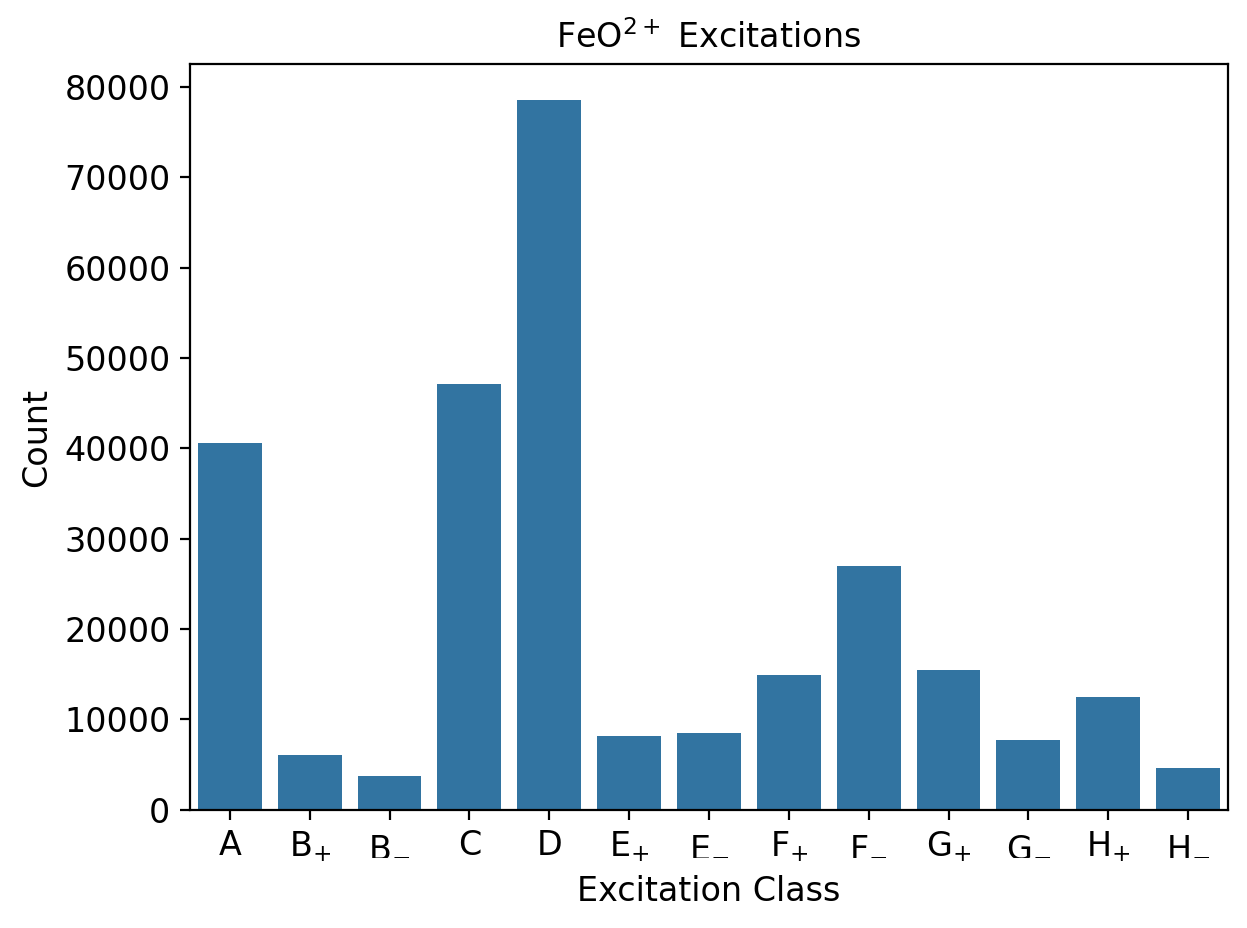

In [48]:
cnttyp0=pd.concat([train_df,test_df])[r'$type_0$'].value_counts().to_frame().sort_index()
cnttyp0.index=[{1:"A", 2:"B$_{+}$", 3:"B$_{-}$", 4:"C", 5:"D", 6:"E$_{+}$", 7:"E$_{-}$", 8:"F$_{+}$", 9:"F$_{-}$", 10:"G$_{+}$", 11:"G$_{-}$", 12:"H$_{+}$", 13:"H$_{-}$"}[t] for t in cnttyp0.index+1]
sns.barplot(data=cnttyp0.reset_index(),x='index',y='count',color=sns.color_palette('Paired')[1])
plt.ylabel('Count')
plt.xlabel('Excitation Class')
# plt.ylim(0,np.round(counttypes.max(), -4))
plt.title('FeO$^{2+}$ Excitations')
plt.tight_layout()

In [49]:
pd.concat([train_df,test_df])['$(F_{r})_{0}$']

A10_A1     1.683883
A10_A10    1.705746
A10_A11    0.519608
A10_A12   -0.784197
A10_A13   -0.784197
             ...   
I9_I5      0.076716
I9_I6      1.575747
I9_I7     -1.183903
I9_I8     -1.183903
I9_I9     -0.804349
Name: $(F_{r})_{0}$, Length: 274972, dtype: float64

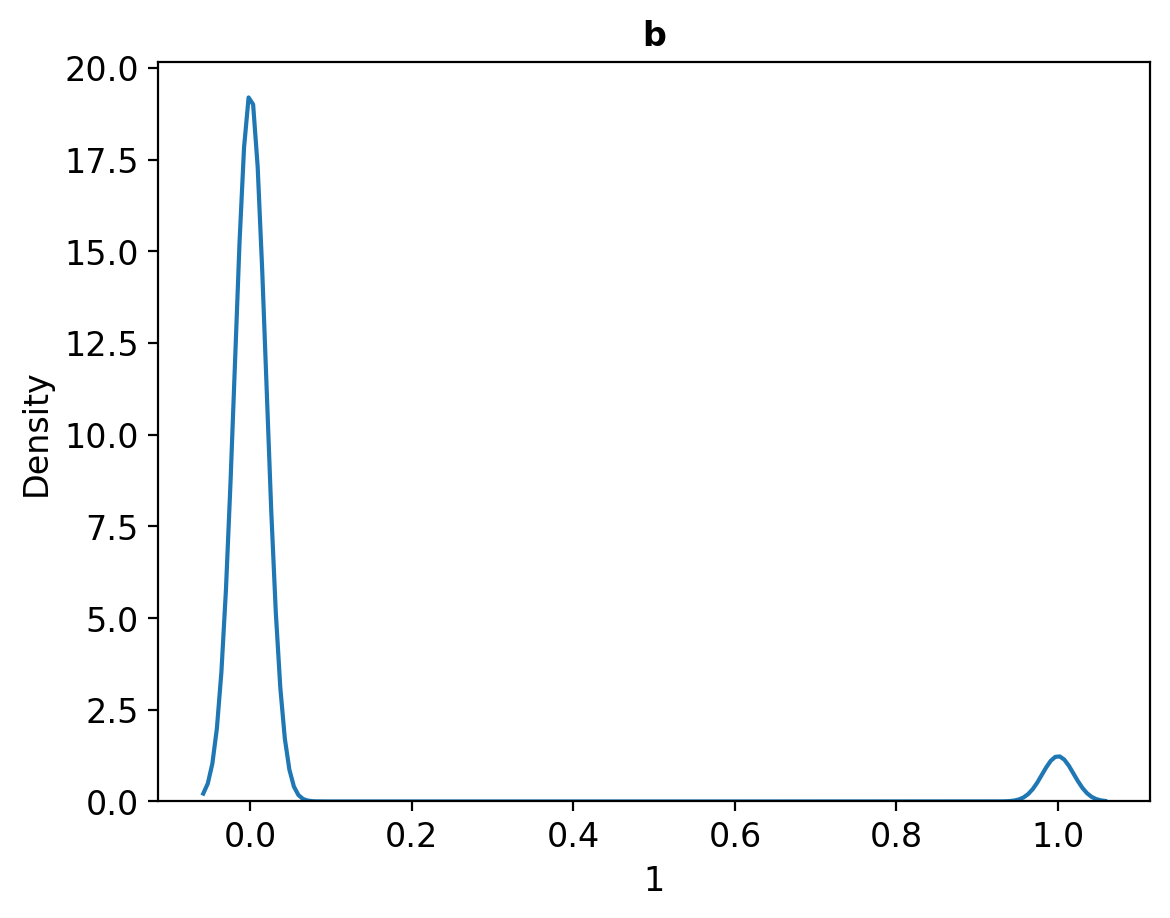

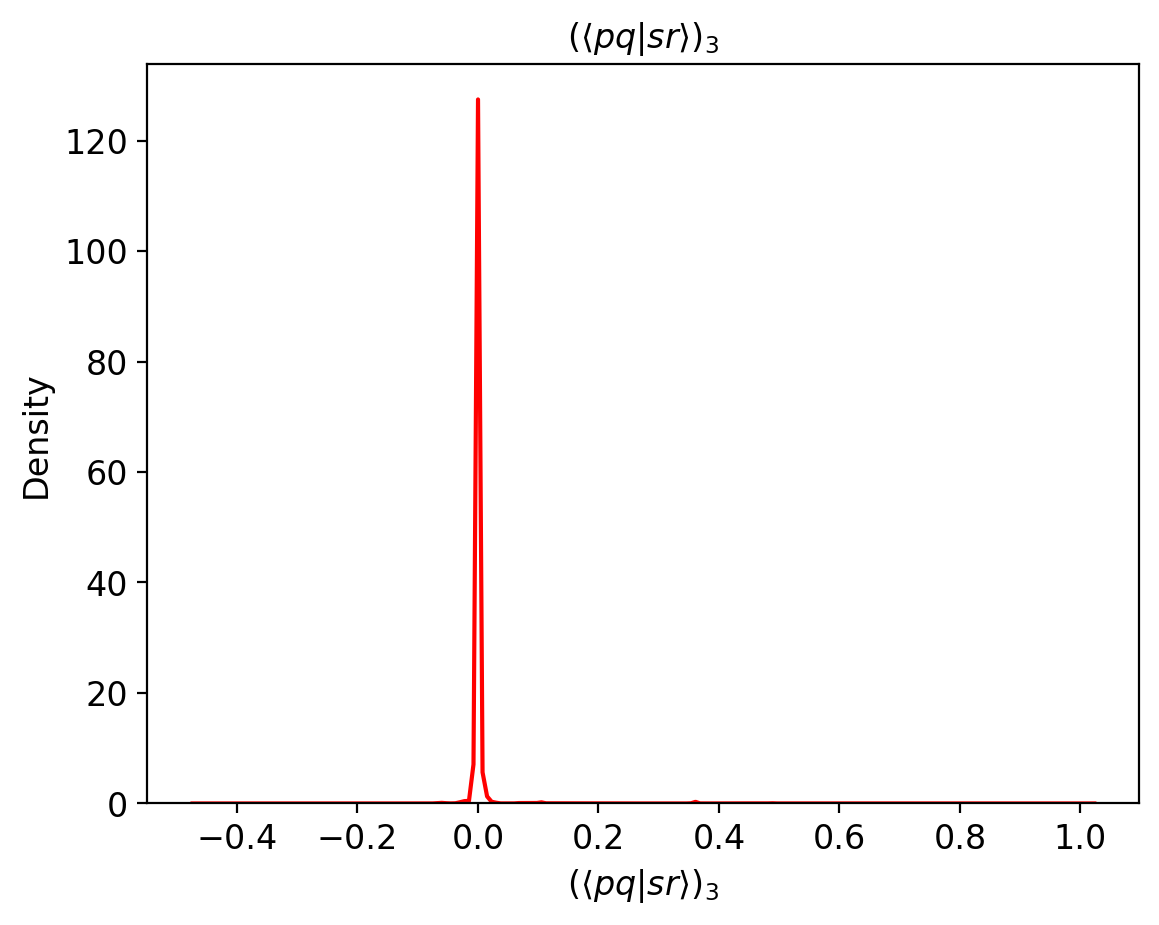

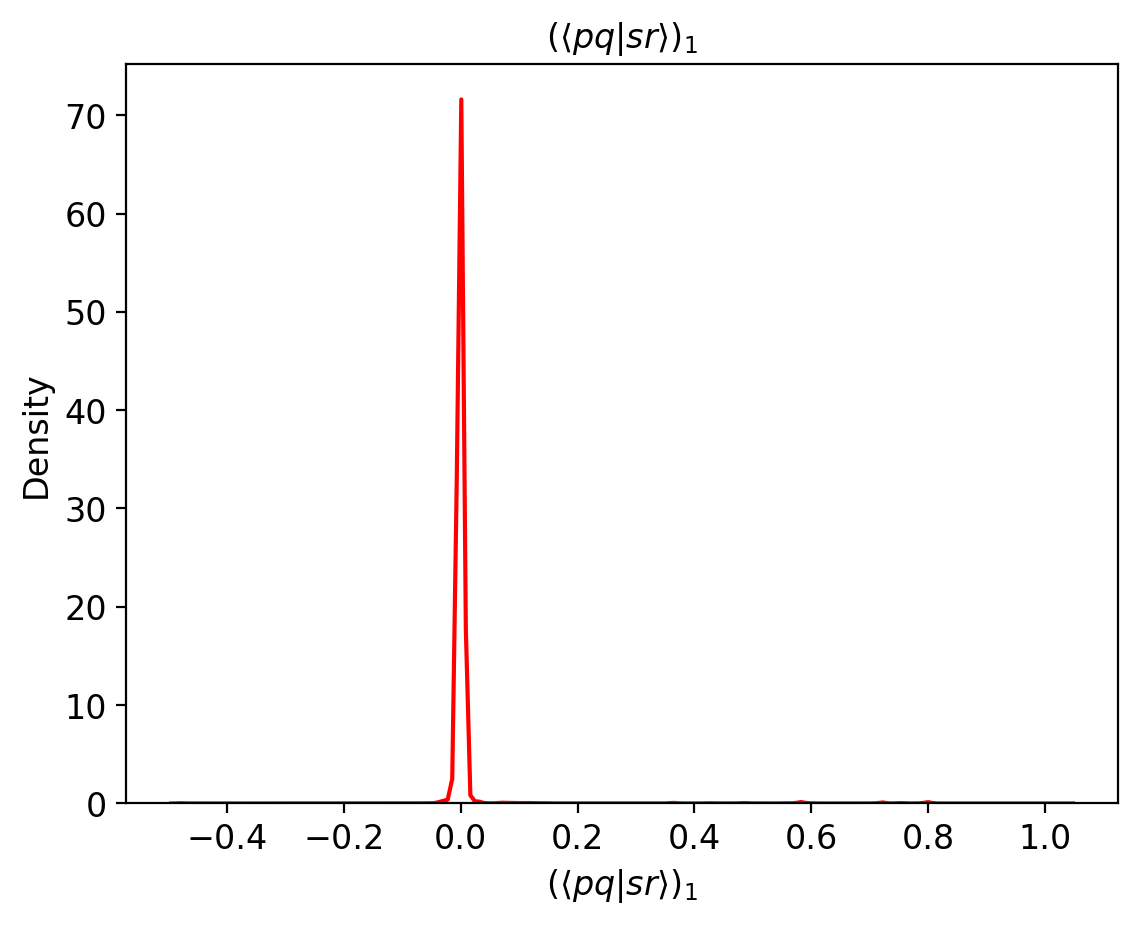

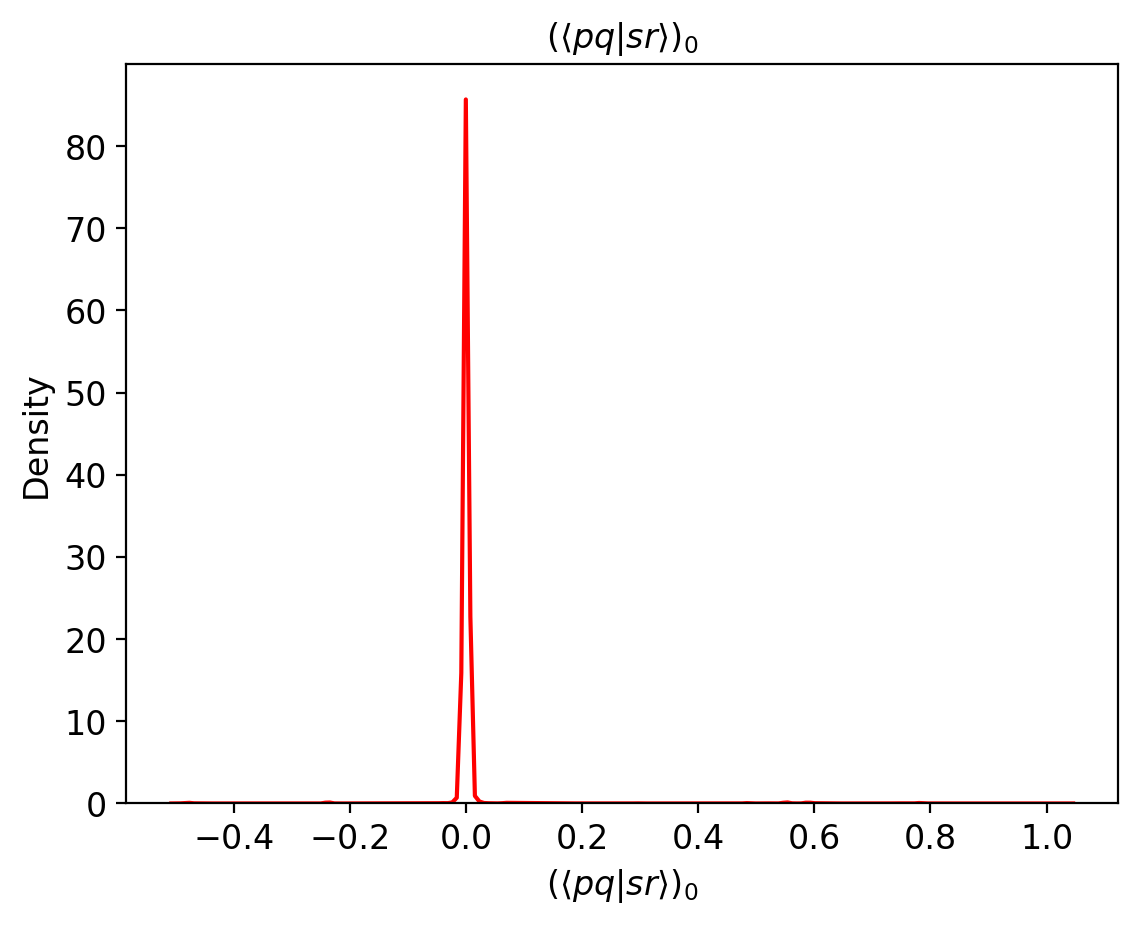

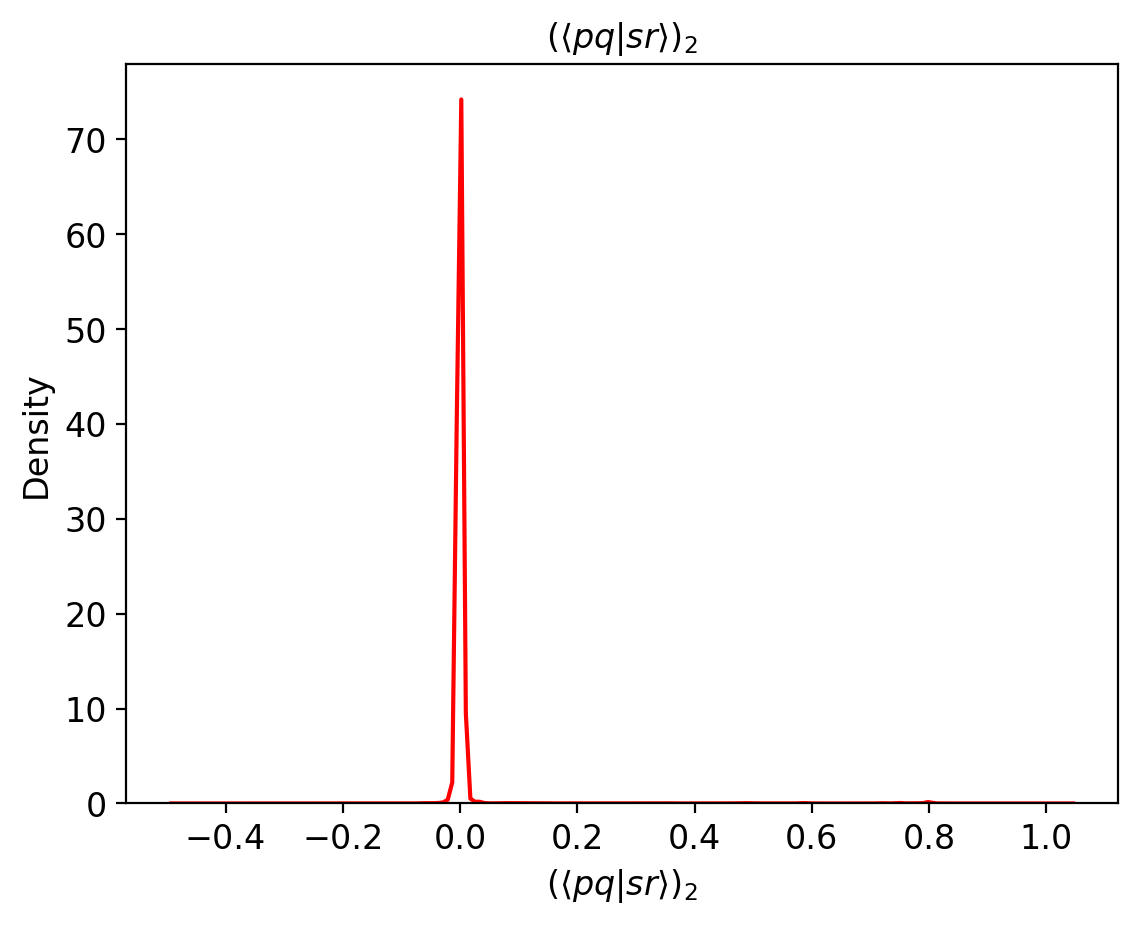

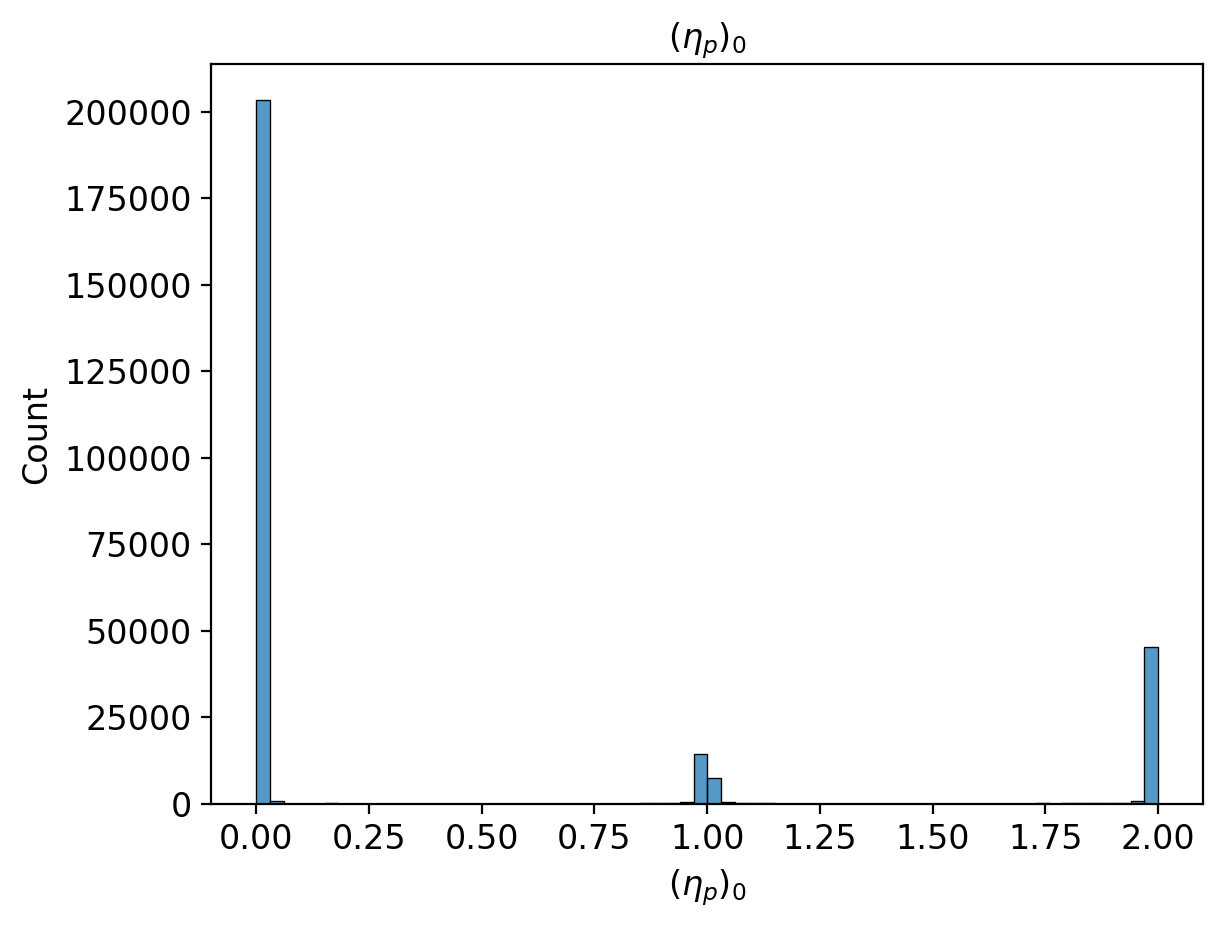

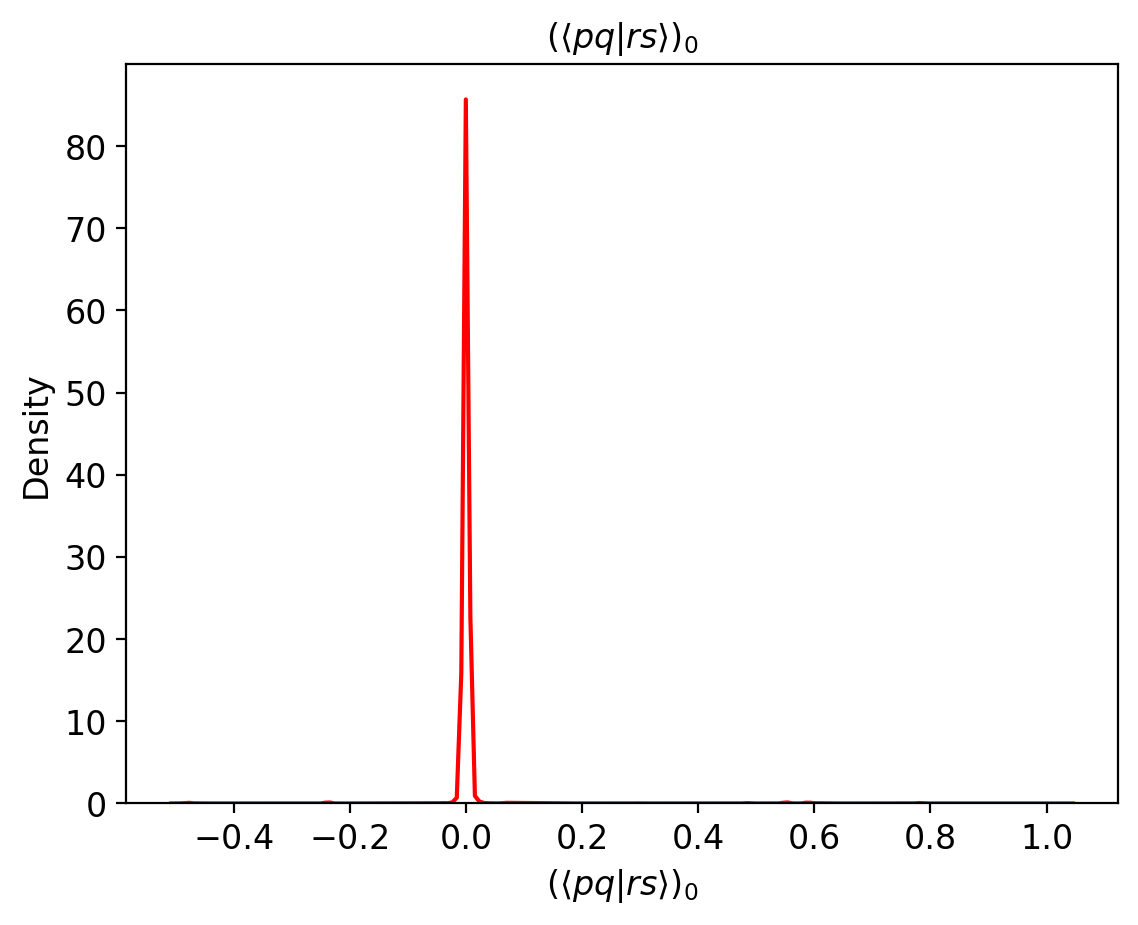

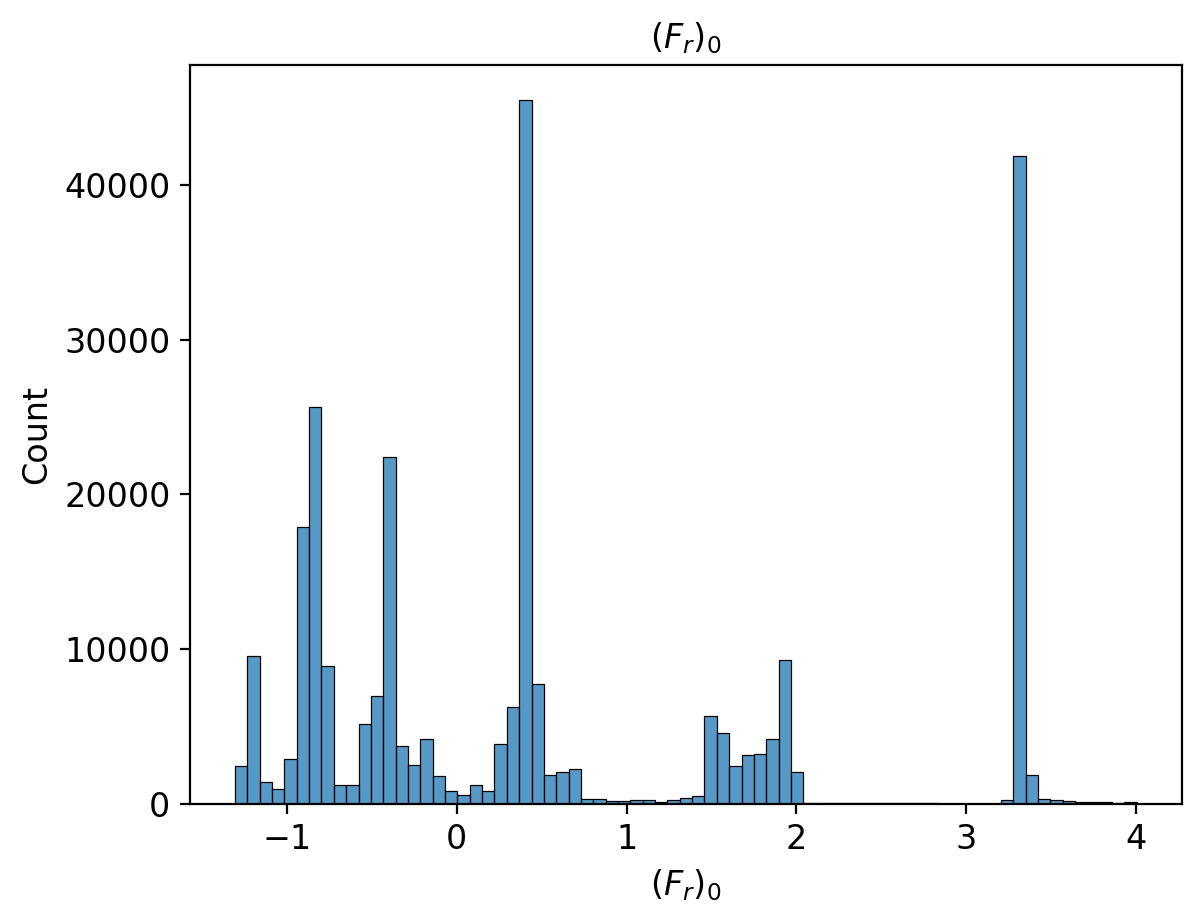

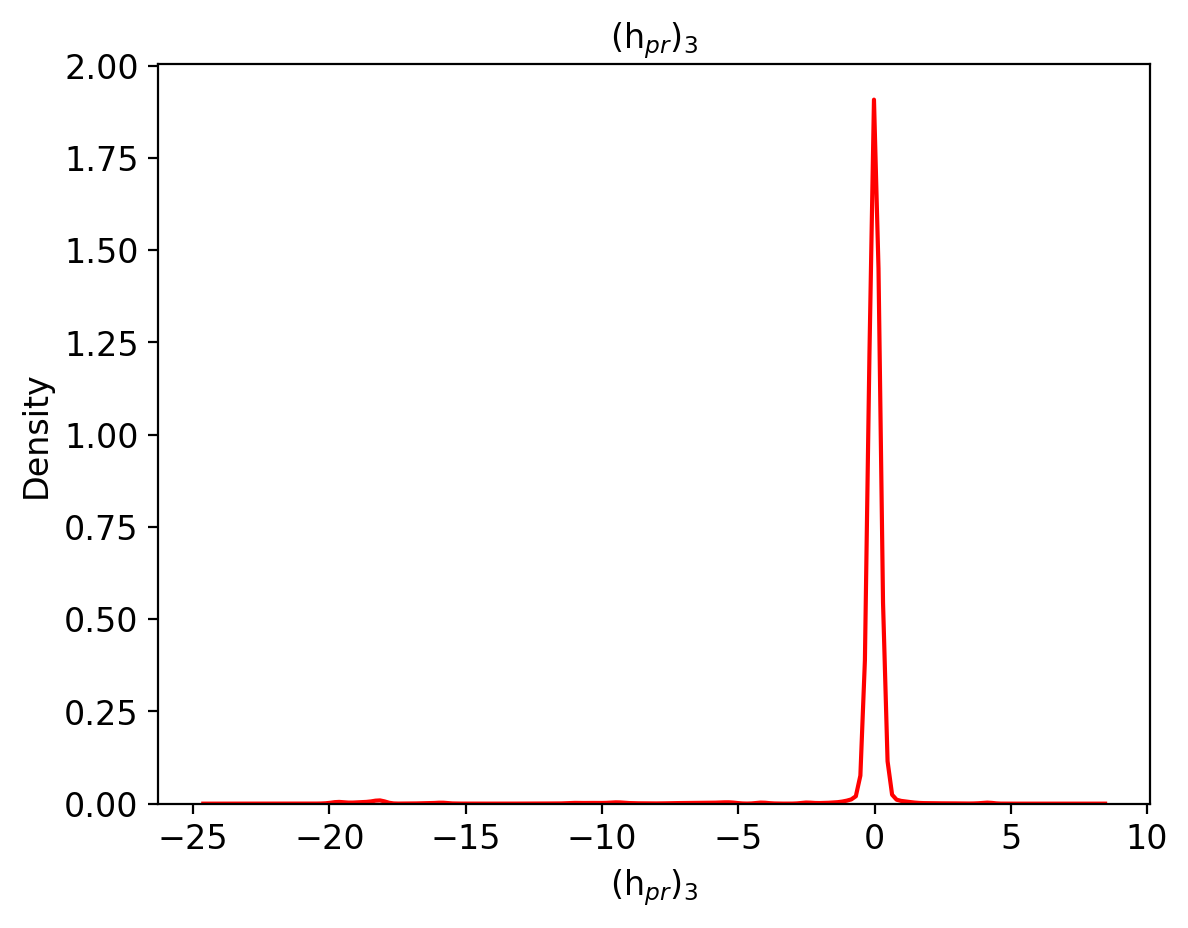

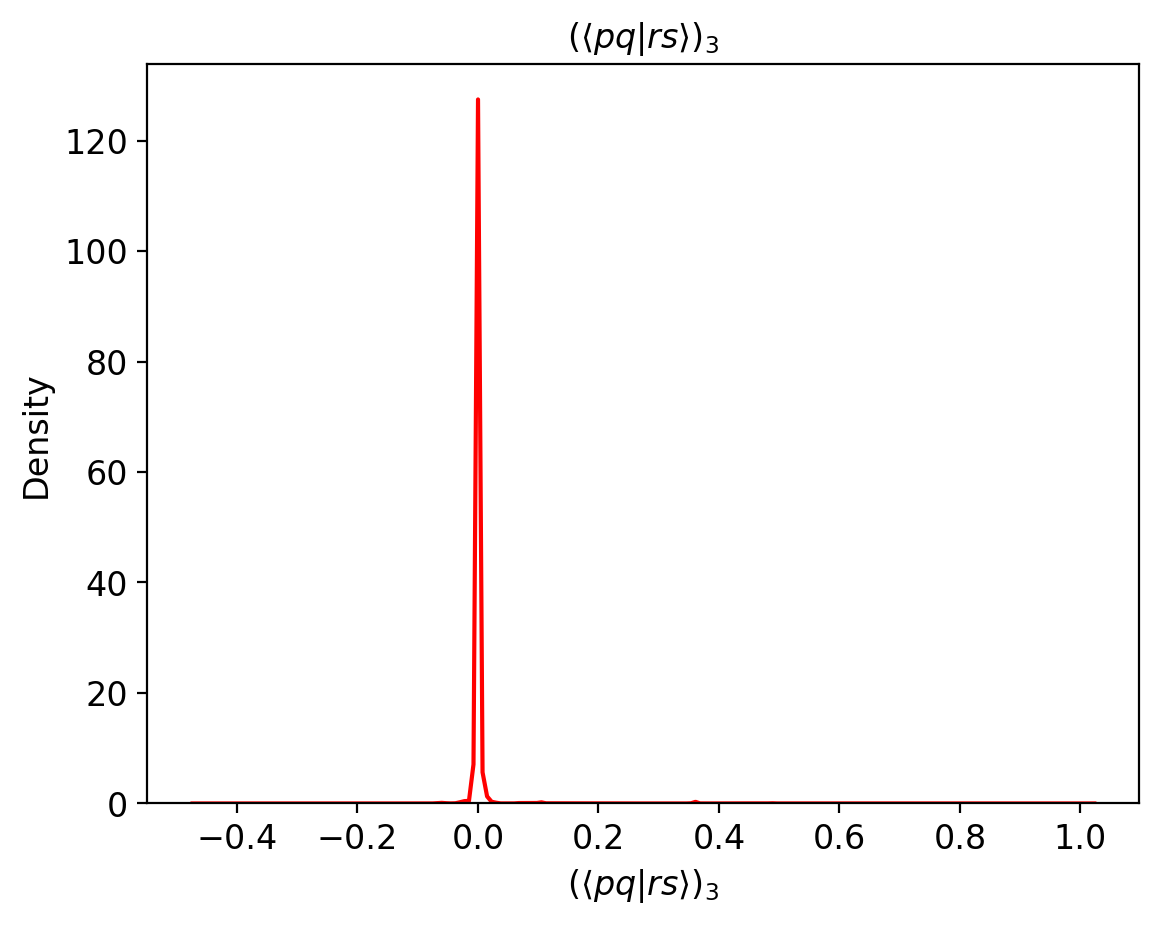

In [50]:
for f in dffeat.sort_values(by='shap').iloc[0:10]['feat']:
    try:
        # print(f,((pd.concat([train_df,test_df])[f]).value_counts()/len(pd.concat([train_df,test_df])[f])).round(2))
        sns.histplot(pd.concat([train_df,test_df])[f])
    except:
        if f=='$\mathbf{b}$':
            sns.kdeplot(pd.concat([train_df,test_df])['1'])
        else:
            sns.kdeplot(pd.concat([train_df,test_df])[fr"{f}"],color='r')
    plt.title(f)
    plt.show()
    # print()

In [51]:
# # plt.figure(figsize=(8,13))
# color_map=sns.color_palette('rocket',6)
# fontsize = 5

# feat_2 = dffeat.sort_values(by=['shap','feat']).iloc[:63]
# feat_1 = dffeat.sort_values(by=['shap','feat']).iloc[63:]


# ax1=feat_1.sort_values(by=['shap','feat']).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax1)
# ax1.bar_label(ax1.containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
# ax1.set_xlim(0,5e-4)
# ax1.set_xticks(np.linspace(0,5e-4,4),[f"{i:.4f}" for i in np.linspace(0,5e-4,4)])
# ax1.set_ylabel('Features',fontsize=fontsize)
# ax1.set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

# ax2=feat_2.sort_values(by=['shap','feat']).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax2)
# ax2.bar_label(ax2.containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
# ax2.set_xlim(0,5e-4)
# ax2.set_xticks(np.linspace(0,5e-4,4),[f"{i:.4f}" for i in np.linspace(0,5e-4,4)])
# ax2.set_ylabel('')
# ax2.set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

# plt.tight_layout()
# # os.mkdir('images')
# plt.savefig('images/Hn_shap_bar.png',dpi=300, bbox_inches='tight')
# plt.show()



In [52]:
r2_score(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])

0.9930158749334738

In [53]:
r2_score(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])

0.9763575126130192

In [54]:
mean_absolute_error(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(0.9783963572039688)

In [55]:
mean_absolute_error(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(1.4848340026945615)